# Lead Scoring Assignment: (first-cut approach)
* Author Mohammed Salman

_Task: Build a model to assign a score between 0 and 100 to leads which can be used by the company to target potential leads._

### Notebook Report/Modeling Development Workflow:

<img src="flow.png">

# Important points and Summary of the Assignment:

__a) Related to Data Analysis__
1. ADs(on all forms of media) seen by people did not indicate if leads turned out to be customers.
2. Geographical location(city/country) of leads did not help in identifying if they would be a customer.
3. Most leads want to get email/call notified but only half of them actually end up being customer; they are interested but something makes them leave.
4. Unemployed leads are larger customer base.
5. Customer conversion from lead is well explained by Lead Quality.
6. 2 out of 3 leads become customers if they send an SMS to Ed. X.
7. If lead states that they will revert after reading email, end up converting to a customer.
8. Most customer base comes from Google, Direct Traffic, Olark Chat; investing in advertising on Google will help bring in more lead convertion.
9. Almost entire customer base is in India.

__b) Related to Model and Metrics__

1. Model prediction(logistic regression) is highly confident in its predictions.
2. False Negative and False Positives are equally important so as to not waste sales time on uninterested leads and not to put a uninterested mark on a lead if they are actually very much invested. (depending on business requirements one could outweight the other)

__c) Failure Cases:__
1. Entering non-sense values into the model that are not valid, will not alert(data engg.)

__d) Lead Score Calculator at the end!__

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
import random
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
import matplotlib as m
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

### Stratified sampling to seperate out test data:

In [2]:
full_data = pd.read_csv('Leads.csv')
y = full_data['Converted']

In [3]:
lead_df, lead_test, _, _ = train_test_split(full_data, y, test_size=0.3, stratify=y)

In [4]:
lead_df = lead_df.reset_index(drop=True)
lead_test = lead_test.reset_index(drop=True)
lead_df

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,b20e6cce-378d-42cf-8575-8278f26616e2,603400,Landing Page Submission,Google,No,No,0,5.0,248,2.5,...,No,Other Leads,Thane & Outskirts,NaN,NaN,NaN,NaN,No,No,Modified
1,d91f5672-34f8-4e6d-95fb-c9cb6c7bf945,586521,Landing Page Submission,Direct Traffic,No,No,0,1.0,554,1.0,...,No,Select,Mumbai,02.Medium,02.Medium,14.0,15.0,No,Yes,Modified
2,0bd6b9cd-012e-4562-ade7-bab97bf6b278,627804,API,Olark Chat,No,No,1,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,14.0,15.0,No,No,Modified
3,95defd68-480b-4ca1-b0c7-0e1ea8dababf,631453,Landing Page Submission,Direct Traffic,No,No,0,3.0,20,3.0,...,No,NaN,Other Metro Cities,NaN,NaN,NaN,NaN,No,Yes,Email Opened
4,eab015ad-8e4c-4d9a-b5d1-4be654a2d138,656682,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,baac69f3-51a0-42d8-b962-402ac79223a5,626794,API,Olark Chat,No,No,0,2.0,130,1.0,...,No,Select,Mumbai,NaN,NaN,NaN,NaN,No,Yes,Modified
6464,a393dd4b-a186-42ce-aead-b943aa70494d,639685,Landing Page Submission,Google,No,No,0,2.0,1269,2.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,18.0,No,No,Modified
6465,057de5d5-de5c-49a2-b905-4ccade9a4125,645294,API,Google,No,No,1,2.0,1520,2.0,...,No,Select,Select,02.Medium,02.Medium,14.0,15.0,No,No,SMS Sent
6466,da2bc7da-2fbf-418a-969b-952975188629,603114,Landing Page Submission,Direct Traffic,Yes,No,0,2.0,1948,2.0,...,No,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Modified


## Exploratory Data Analysis:
1. Indentify missing values
2. Univariate Analysis on non-missing values

### Identify missing values in the data

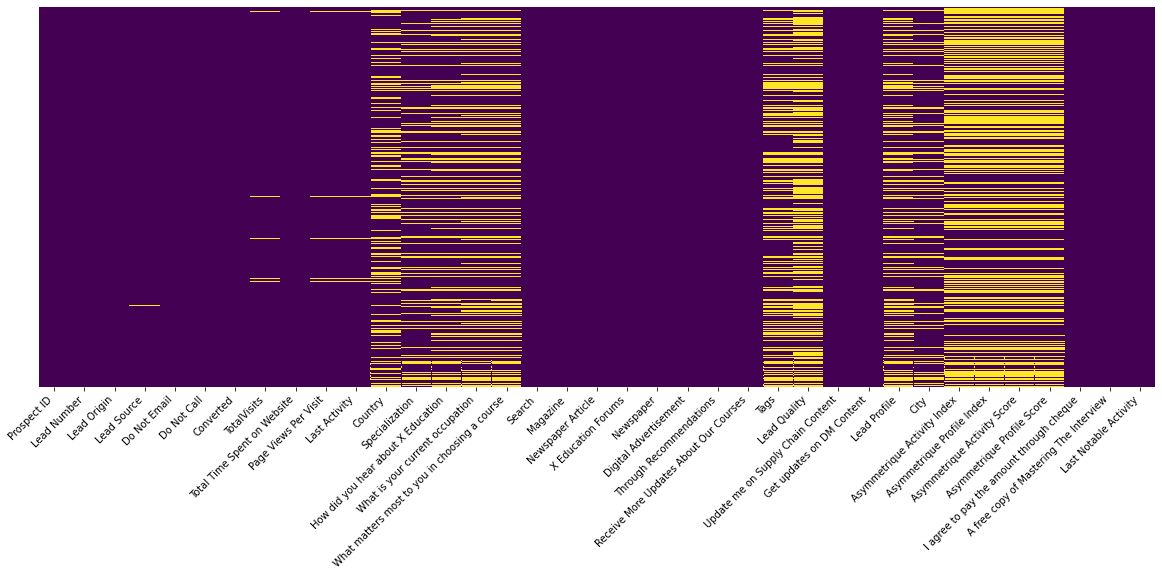

In [5]:
plt.figure(figsize=(20,7))

g = sns.heatmap(lead_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
f = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

#### To check if Prospect ID is unique: (for duplicate records of a person)

In [6]:
len(set(lead_df['Prospect ID'])) == len(lead_df['Prospect ID'])

True

In [7]:
(lead_df.isna().sum()*100)/len(lead_df)

Prospect ID                                       0.000000
Lead Number                                       0.000000
Lead Origin                                       0.000000
Lead Source                                       0.417440
Do Not Email                                      0.000000
Do Not Call                                       0.000000
Converted                                         0.000000
TotalVisits                                       1.515152
Total Time Spent on Website                       0.000000
Page Views Per Visit                              1.515152
Last Activity                                     1.128633
Country                                          26.221398
Specialization                                   15.692641
How did you hear about X Education               24.335189
What is your current occupation                  29.916512
What matters most to you in choosing a course    30.117502
Search                                            0.0000

### Identify categorical and numerical features: (rouch check of features)

In [8]:
# Consider it a category if there are 20 or less unique values for first glance
thresh = 20

if [col for col in lead_df.columns if len(lead_df[col].unique()) <=thresh]:
     cat_var = [col for col in lead_df.columns if len(lead_df[col].unique()) <=thresh]  
if [col for col in lead_df.columns if len(lead_df[col].unique()) > thresh]:
     num_var = [col for col in lead_df.columns if len(lead_df[col].unique()) > thresh]
        
print('Categorical columns are: ', cat_var, len(cat_var))
print('\n\nNumerical columns are: ', num_var, len(num_var))

Categorical columns are:  ['Lead Origin', 'Do Not Email', 'Do Not Call', 'Converted', 'Last Activity', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Lead Quality', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity'] 29


Numerical columns are:  ['Prospect ID', 'Lead Number', 'Lead Source', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Country', 'Tags'] 8


In [9]:
lead_df['Country'].unique()

array(['India', nan, 'South Africa', 'United States', 'Canada',
       'United Arab Emirates', 'Kuwait', 'Bahrain', 'Bangladesh',
       'Singapore', 'Saudi Arabia', 'Hong Kong', 'unknown', 'Denmark',
       'Belgium', 'Germany', 'Sweden', 'Australia', 'Malaysia', 'Italy',
       'United Kingdom', 'China', 'Asia/Pacific Region', 'Sri Lanka',
       'Switzerland', 'Russia', 'Nigeria', 'Oman', 'Ghana', 'Netherlands',
       'France', 'Qatar', 'Philippines', 'Uganda'], dtype=object)

## Univariate Analysis:
* Below univariate analysis is done on categorical features first

In [10]:
### Helper function to plot (thats why no doc string!)####
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='Converted', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Leads')
    plt.title('% of leads')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'converted lead'))
    plt.show()

In [11]:
### Helper function to plot ####
def univariate_barplots(data, col1, col2='Converted', top=False):
    temp = pd.DataFrame(lead_df.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
    temp['total'] = pd.DataFrame(lead_df.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Converted%'] = pd.DataFrame(lead_df.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg'] * 100
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    temp = temp.sort_values(by='total', ascending=False)
    print(temp.head(5))
    print("="*50)

### Distribution of Response variable:

In [12]:
sns.set_style("whitegrid")
sns.set_palette("bright")

<AxesSubplot:xlabel='Converted', ylabel='Count'>

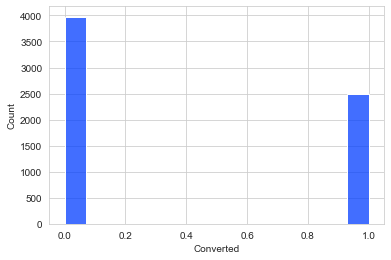

In [13]:
# Working with 9k data points how many are converted and not converted:
sns.histplot(data=lead_df, x="Converted")

In [14]:
lead_df['Converted'].unique()

array([0, 1], dtype=int64)

#### Summary of above graph:
* Lead not converted stands at ~60% (3900/6500) and lead converted ~40% (2600/6500)
* More of leads not getting converted but : Fairly balanced dataset

### 1.Lead Origin vs response variable

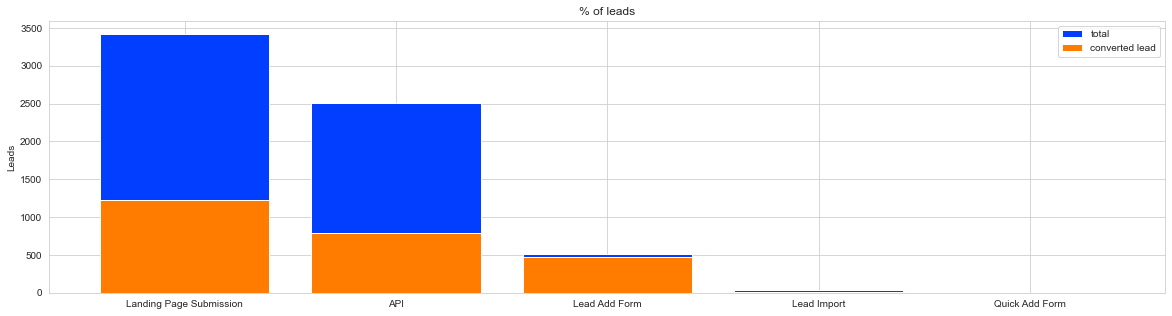

               Lead Origin  Converted  total  Converted%
1  Landing Page Submission       1227   3419   35.887686
0                      API        785   2503   31.362365
2            Lead Add Form        469    507   92.504931
3              Lead Import         11     38   28.947368
4           Quick Add Form          1      1  100.000000


In [15]:
univariate_barplots(lead_df, 'Lead Origin', 'Converted', False)

#### Summary of above graph:
* If it was a API/ Langing Page Submission there is a 1 out of 3 rate of leads getting converted (high significance)
* Lead Add Form shows that 92% of the leads got converted (significance of this category is about 8% of 6500 total data points)


### 2.Do Not Email vs response variable

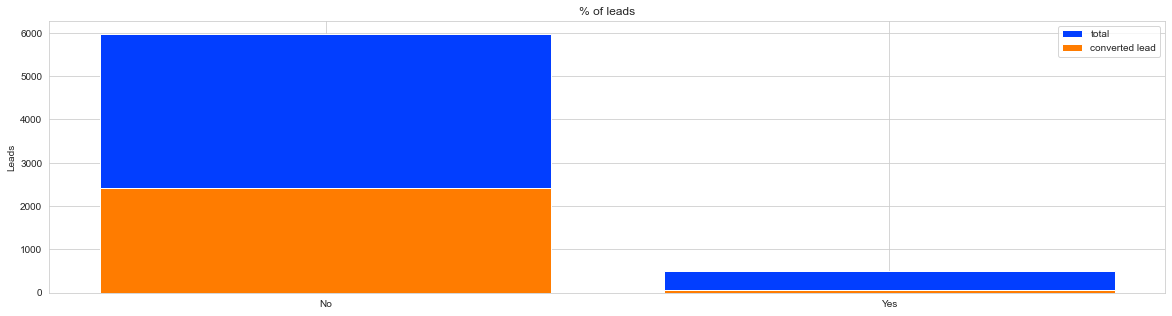

  Do Not Email  Converted  total  Converted%
0           No       2417   5974   40.458654
1          Yes         76    494   15.384615


In [16]:
univariate_barplots(lead_df, 'Do Not Email', 'Converted', False)

#### Summary of above graph:
* 40% rate of getting converted/paying customer if they didnt mind to get emailed (high significance)
* Only 2 of 10 people who didnt want to get emailed got converted (significance of this category is about 8% of 9200 total data points)
* If they mention Do not email, theres a high chance of not being a potential lead

### 3.Do Not Call vs response variable

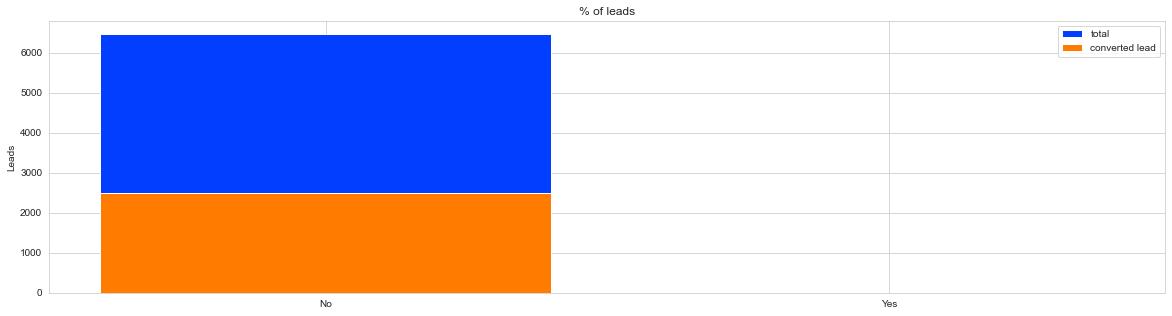

  Do Not Call  Converted  total  Converted%
0          No       2492   6467   38.534096
1         Yes          1      1  100.000000


In [17]:
univariate_barplots(lead_df, 'Do Not Call', 'Converted', False)

#### Summary of above graph:
* 40% rate of getting converted/paying customer if they didnt mind to get called (high significance)
* Entire population didnt mind getting called about the education program

### 4.What is your current occupation vs response variable

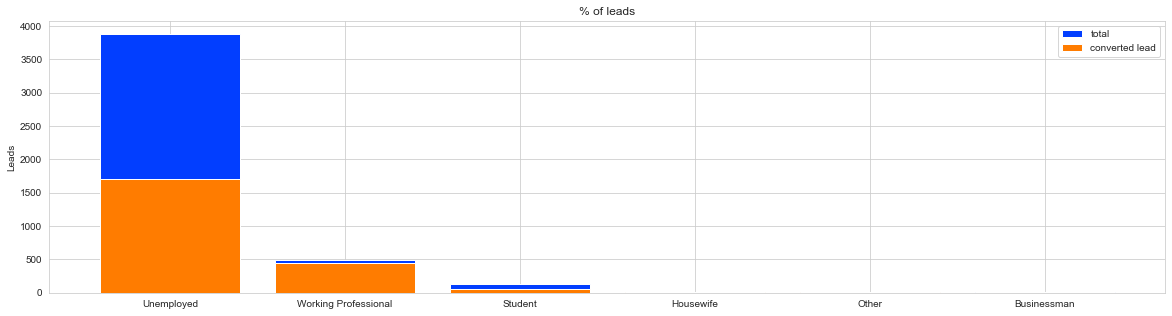

  What is your current occupation  Converted  total  Converted%
4                      Unemployed       1710   3882   44.049459
5            Working Professional        448    491   91.242363
3                         Student         52    136   38.235294
1                       Housewife          9      9  100.000000
2                           Other          6      9   66.666667


In [18]:
univariate_barplots(lead_df, 'What is your current occupation', 'Converted', False)

#### Summary of above graph:
* ~40% rate of getting converted/paying customer if they were unemployed (high significance)
* 90+% of working professionals become a paying customer! (significance of this category is about 8% of 6500 total data points)
* NOTE: ~30% of data is missing for this category.

### 5.What matters most to you in choosing a course vs response variable

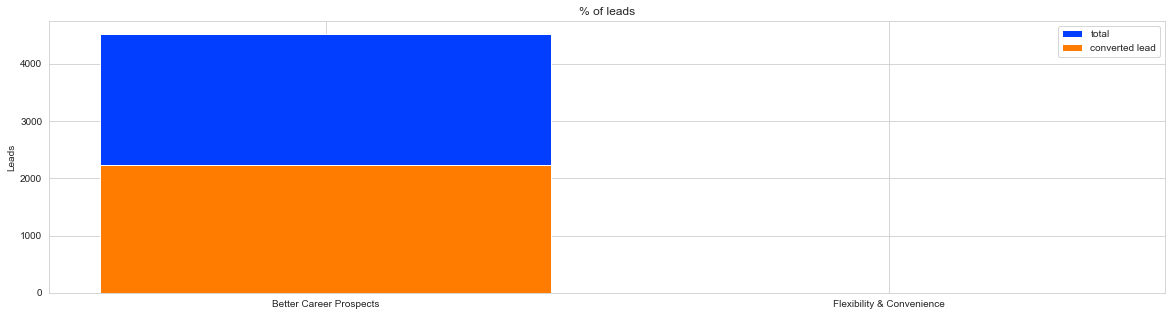

  What matters most to you in choosing a course  Converted  total  Converted%
0                       Better Career Prospects       2228   4518   49.313856
1                     Flexibility & Convenience          1      2   50.000000


In [19]:
univariate_barplots(lead_df, 'What matters most to you in choosing a course', 'Converted', False)

#### Summary of above graph:
* almost 50% of converted lead wanted a better Career (high significance)
* NOTE: ~30% of data is missing for this category.

### 6.Search(AD) vs response variable

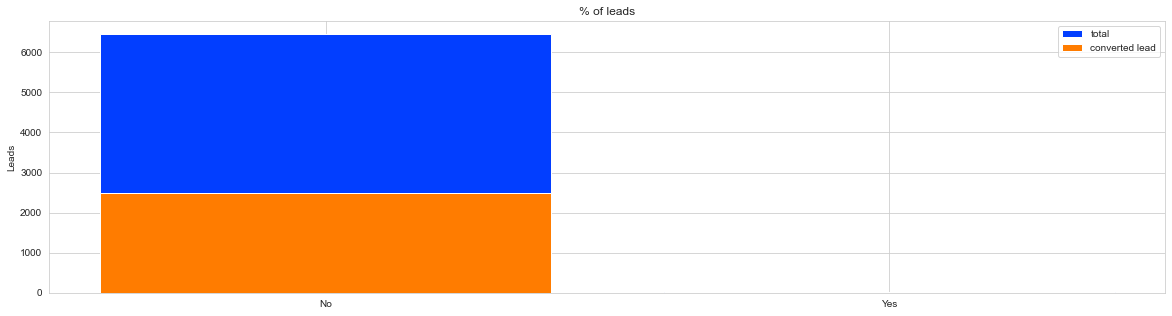

  Search  Converted  total  Converted%
0     No       2489   6458   38.541344
1    Yes          4     10   40.000000


In [20]:
univariate_barplots(lead_df, 'Search', 'Converted', False)

#### Summary of above graph:
* Data not enough on 'YES'
* If they didnt see a SEARCH AD, more than 1/3rd still got converted (high significance)

### 7.Magazine(AD) vs response variable

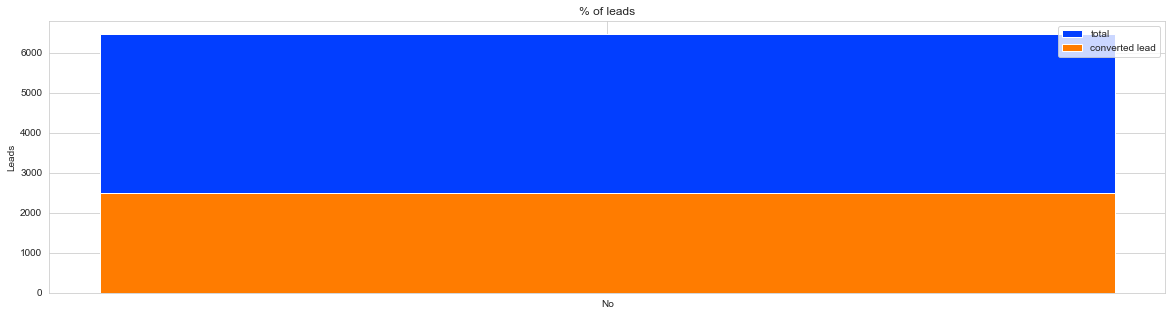

  Magazine  Converted  total  Converted%
0       No       2493   6468   38.543599


In [21]:
univariate_barplots(lead_df, 'Magazine', 'Converted', False)

#### Summary of above graph:
* About 40% didnt see the AD on MAGAZINE and decided to ultimately pay and become a customer.
* There is no 'YES' data (data collection, from modeling standpoint, possibly redundant feature)

### 8.Newspaper Article(AD) vs response variable

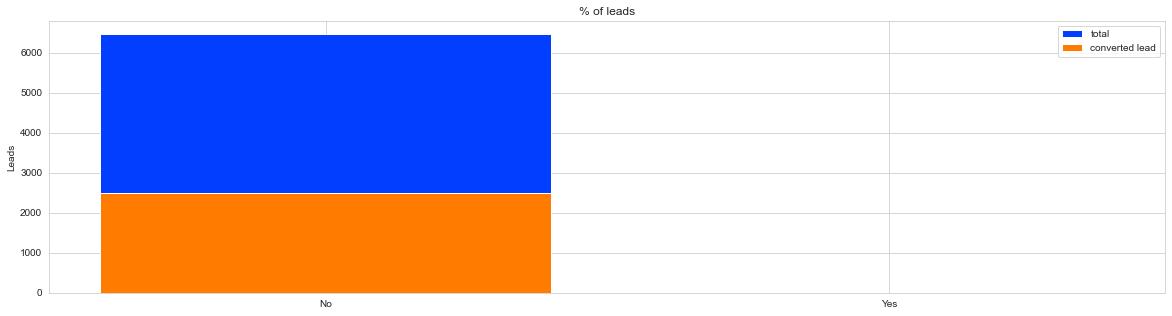

  Newspaper Article  Converted  total  Converted%
0                No       2492   6467   38.534096
1               Yes          1      1  100.000000


In [22]:
univariate_barplots(lead_df, 'Newspaper Article', 'Converted', False)

#### Summary of above graph:
* About 40% didnt see the AD on NEWSPAPER and decided to ultimately pay and become a customer.
* There is almost no 'YES' data (data collection, from modeling standpoint, possibly redundant feature)
* How was this data collected? How do you know the customer actually saw the ad, did we collect this data based on just ad on newspaper purchase?

### 9.Newspaper (AD) vs response variable

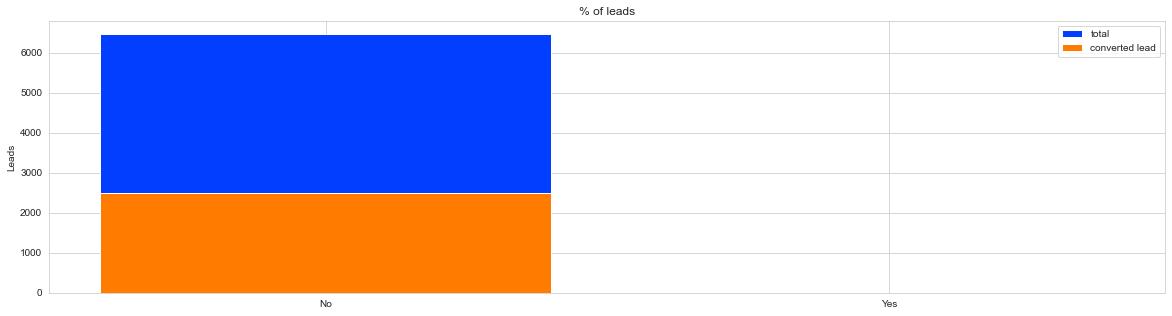

  Newspaper  Converted  total  Converted%
0        No       2493   6467   38.549559
1       Yes          0      1    0.000000


In [23]:
univariate_barplots(lead_df, 'Newspaper', 'Converted', False)

#### Summary of above graph:
* About 40% didnt see the AD on NEWSPAPER and decided to ultimately pay and become a customer.
* There is almost no 'YES' data (data collection, from modeling standpoint, possibly redundant feature)
* How was this data collected? How do you know the customer actually saw the ad, did we collect this data based on just ad on newspaper purchase?

### 10.Digital Advertisement (AD) vs response variable

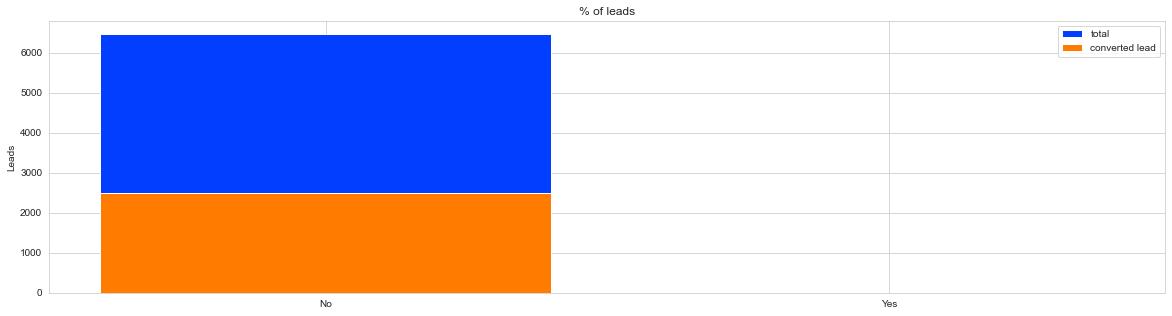

  Digital Advertisement  Converted  total  Converted%
0                    No       2492   6465   38.546017
1                   Yes          1      3   33.333333


In [24]:
univariate_barplots(lead_df, 'Digital Advertisement', 'Converted', False)

#### Summary of above graph:
* About 40% didnt see the AD on Digital Advertisement and decided to ultimately pay and become a customer.
* There is almost no 'YES' data (data collection, from modeling standpoint, possibly redundant feature)
* How was this data collected? How do you know the customer actually saw the ad, did we collect this data based on just ad on Digital Advertisement ?

### 11.X Education Forums (AD) vs response variable

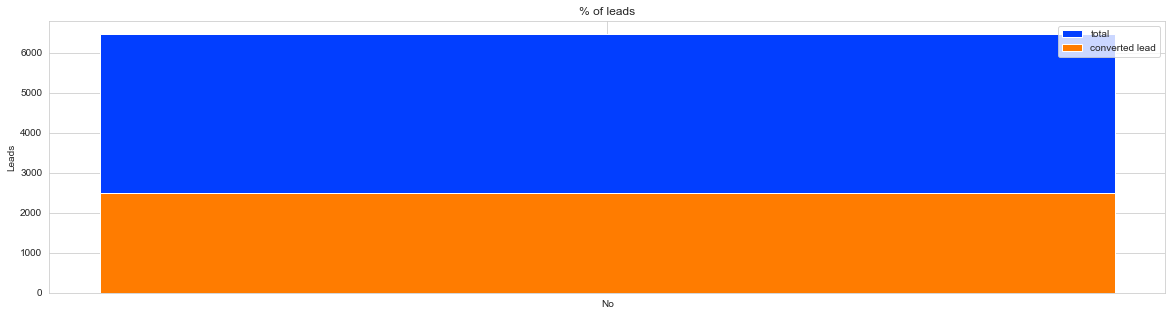

  X Education Forums  Converted  total  Converted%
0                 No       2493   6468   38.543599


In [25]:
univariate_barplots(lead_df, 'X Education Forums', 'Converted', False)

#### Summary of above graph:
* About 40% didnt see the AD on Digital Advertisement and decided to ultimately pay and become a customer.
* There is almost no 'YES' data (data collection, from modeling standpoint, possibly redundant feature)
* How was this data collected? How do you know the customer actually saw the ad, did we collect this data based on just ad on Digital Advertisement ?

### 12.Lead Quality vs response variable

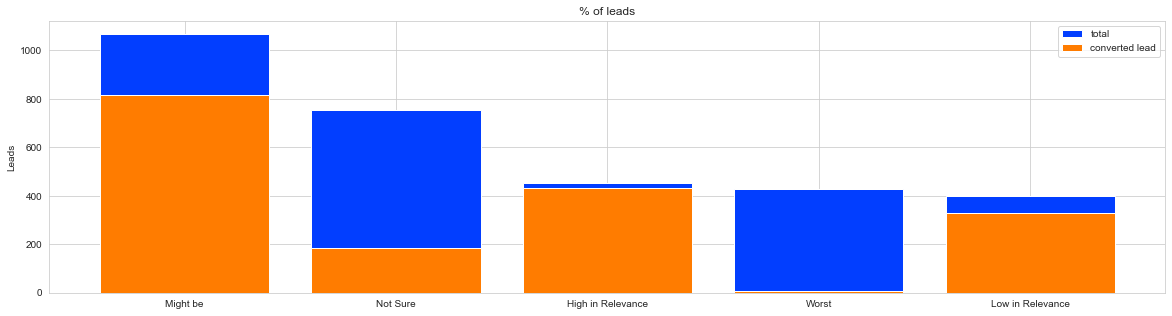

        Lead Quality  Converted  total  Converted%
2           Might be        815   1068   76.310861
3           Not Sure        184    755   24.370861
0  High in Relevance        434    451   96.230599
4              Worst          8    428    1.869159
1   Low in Relevance        329    401   82.044888


In [26]:
univariate_barplots(lead_df, 'Lead Quality', 'Converted', False)

#### Summary of above graph:
* ~95% of high in relevance actually did become a customer.
* 75-80% of low in relevance/might be actually did become a customer
* Worst/Not sure indicates a high rate of not becoming a eventual customer

### 13.Lead Profile vs response variable

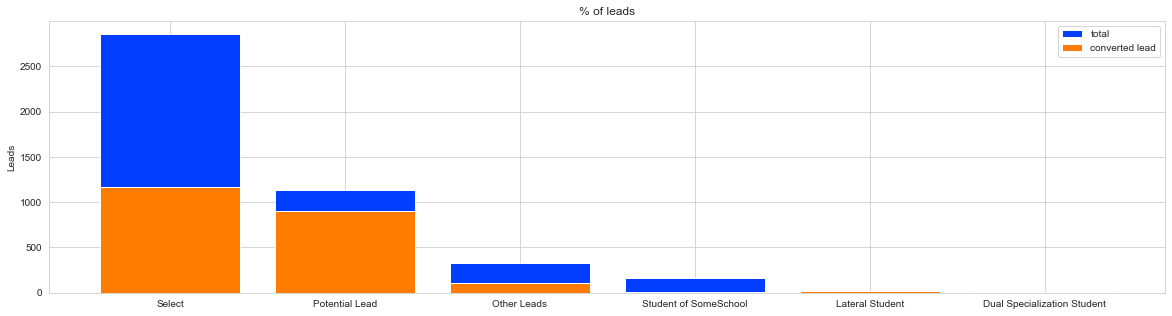

            Lead Profile  Converted  total  Converted%
4                 Select       1172   2856   41.036415
3         Potential Lead        906   1131   80.106101
2            Other Leads        113    333   33.933934
5  Student of SomeSchool          7    168    4.166667
1        Lateral Student         17     18   94.444444


In [27]:
univariate_barplots(lead_df, 'Lead Profile', 'Converted', False)

#### Summary of above graph:
* Potential lead implies ~80% rate of becoming a customer.
* What does select mean? It has 40% rate of becoming a customer.

### 14.Get updates on DM Content vs response variable

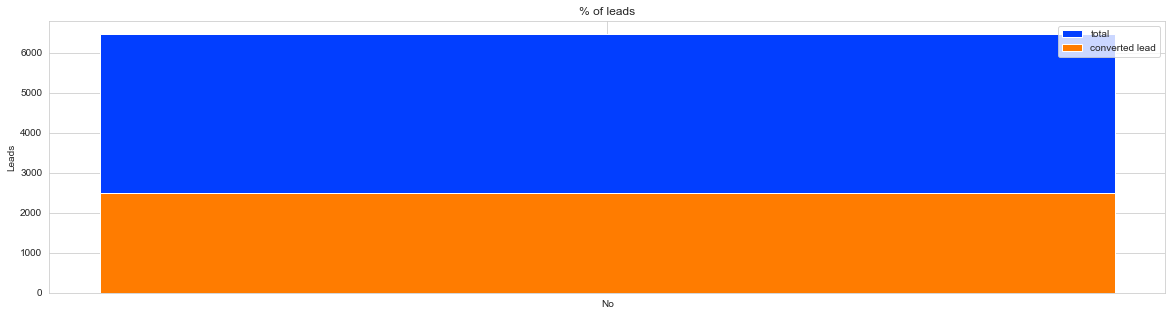

  Get updates on DM Content  Converted  total  Converted%
0                        No       2493   6468   38.543599


In [28]:
univariate_barplots(lead_df, 'Get updates on DM Content', 'Converted', False)

#### Summary of above graph:
* Only No data present, people dont want updates from DM content.

### 15.Update me on Supply Chain Content vs response variable

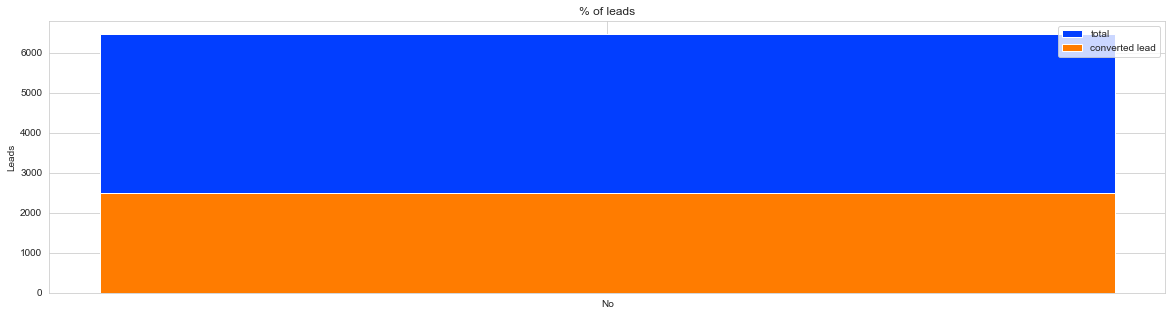

  Update me on Supply Chain Content  Converted  total  Converted%
0                                No       2493   6468   38.543599


In [29]:
univariate_barplots(lead_df, 'Update me on Supply Chain Content', 'Converted', False)

#### Summary of above graph:
* Only No data present, people dont want updates from Supply Chain Content.

### 16.Receive More Updates About Our Courses vs response variable

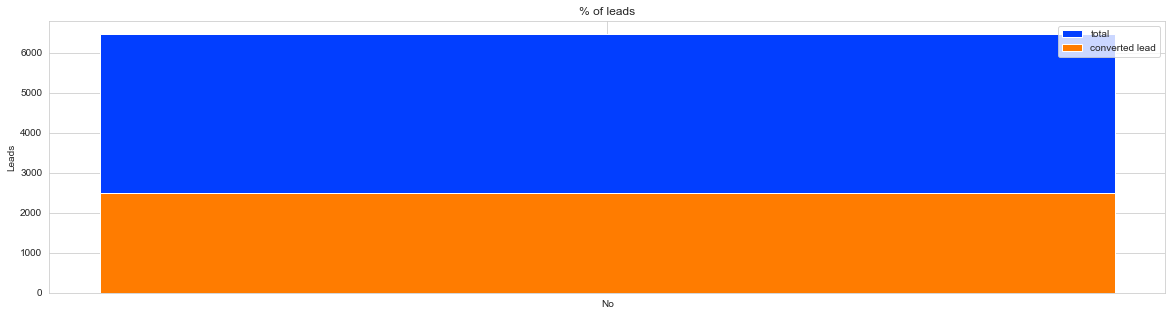

  Receive More Updates About Our Courses  Converted  total  Converted%
0                                     No       2493   6468   38.543599


In [30]:
univariate_barplots(lead_df, 'Receive More Updates About Our Courses', 'Converted', False)

#### Summary of above graph:
* Only No data present.

### 17.Through Recommendations vs response variable

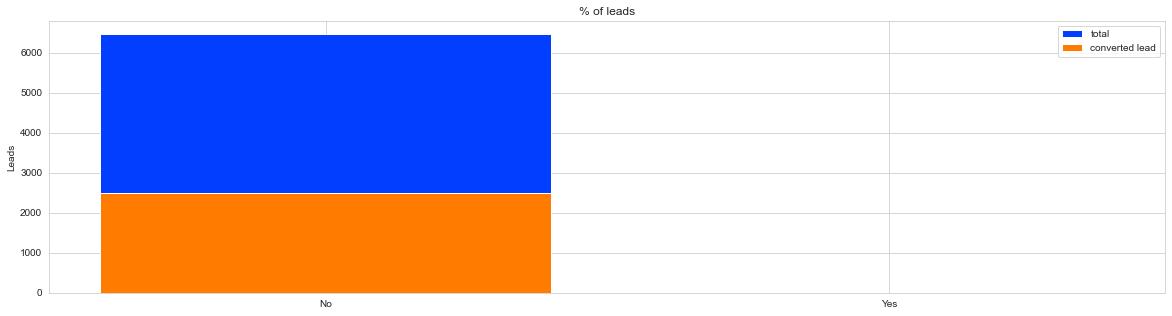

  Through Recommendations  Converted  total  Converted%
0                      No       2489   6464   38.505569
1                     Yes          4      4  100.000000


In [31]:
univariate_barplots(lead_df, 'Through Recommendations', 'Converted', False)

#### Summary of above graph:
* Only No data present.

### 18.A free copy of Mastering The Interview vs response variable

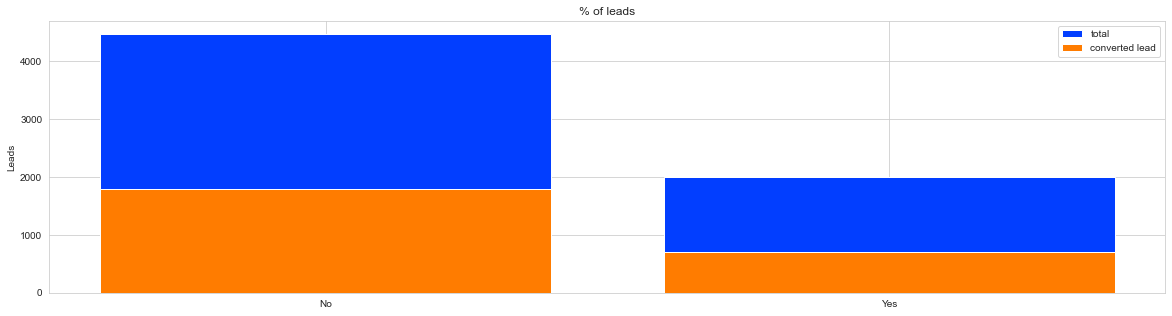

  A free copy of Mastering The Interview  Converted  total  Converted%
0                                     No       1795   4464   40.210573
1                                    Yes        698   2004   34.830339


In [32]:
univariate_barplots(lead_df, 'A free copy of Mastering The Interview', 'Converted', False)

#### Summary of above graph:
* If they wanted a copy or not, only 35-40% become paying customer.

### 19.City vs response variable

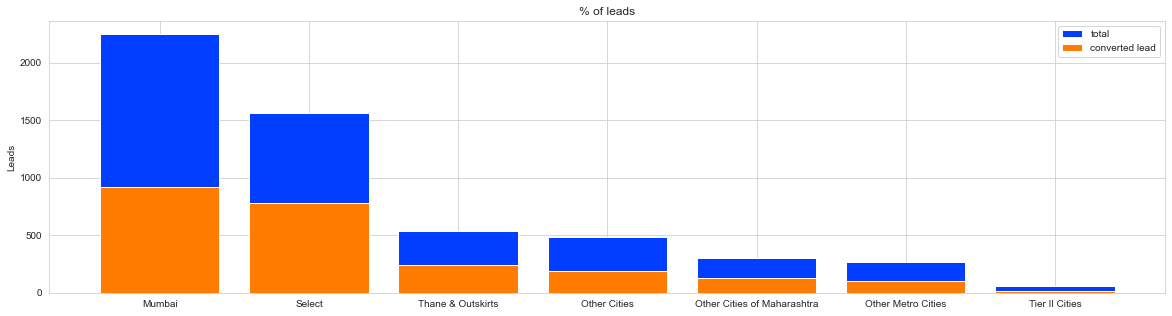

                          City  Converted  total  Converted%
0                       Mumbai        922   2248   41.014235
4                       Select        776   1561   49.711723
5            Thane & Outskirts        245    536   45.708955
1                 Other Cities        190    488   38.934426
2  Other Cities of Maharashtra        130    305   42.622951


In [33]:
univariate_barplots(lead_df, 'City', 'Converted', False)

#### Summary of above graph:
* 50% of converted leads dont even select from drop down (?)
* Most traffic is in Mumbai, theres a 40% rate they become a customer, as with other locations.

### 20.I agree to pay the amount through cheque vs response variable

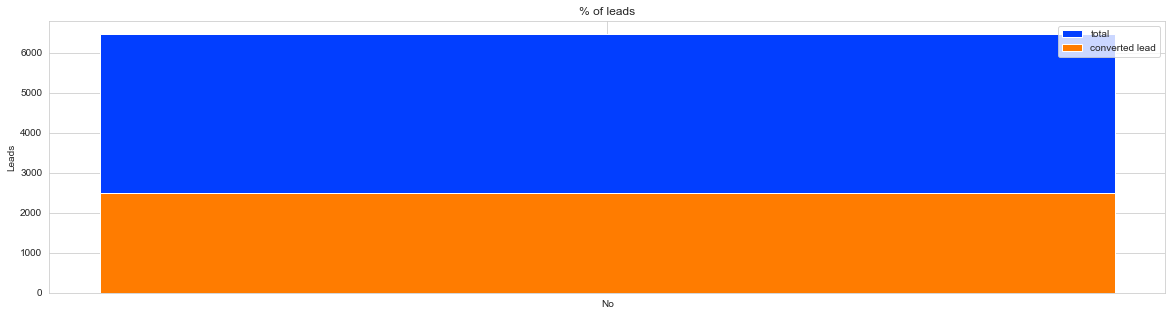

  I agree to pay the amount through cheque  Converted  total  Converted%
0                                       No       2493   6468   38.543599


In [34]:
univariate_barplots(lead_df, 'I agree to pay the amount through cheque', 'Converted', False)

#### Summary of above graph:
* Not relevant.

### 21.Asymmetrique Activity Index vs response variable

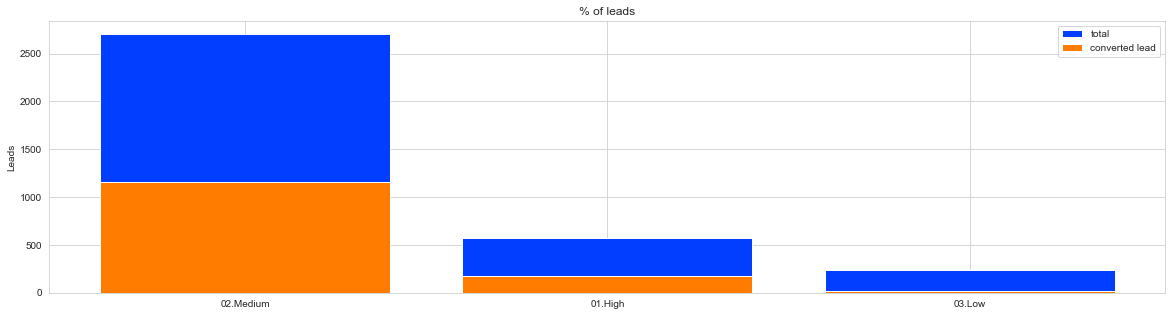

  Asymmetrique Activity Index  Converted  total  Converted%
1                   02.Medium       1155   2705   42.698706
0                     01.High        171    577   29.636049
2                      03.Low         23    240    9.583333


In [35]:
univariate_barplots(lead_df, 'Asymmetrique Activity Index', 'Converted', False)

#### Summary of above graph:
* Not Relevant.

### 22.Asymmetrique Activity Index vs response variable

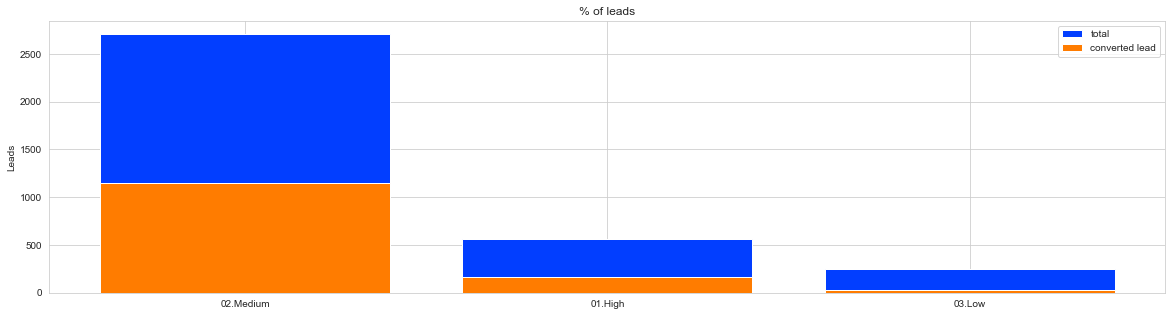

  Asymmetrique Activity Index  Converted  total  Converted%
1                   02.Medium       1145   2709   42.266519
0                     01.High        165    563   29.307282
2                      03.Low         27    245   11.020408


In [37]:
univariate_barplots(lead_df, 'Asymmetrique Activity Index', 'Converted', False)

#### Summary of above graph:
* Collinear to Asym.Profile index.

### 23.Tags vs response variable

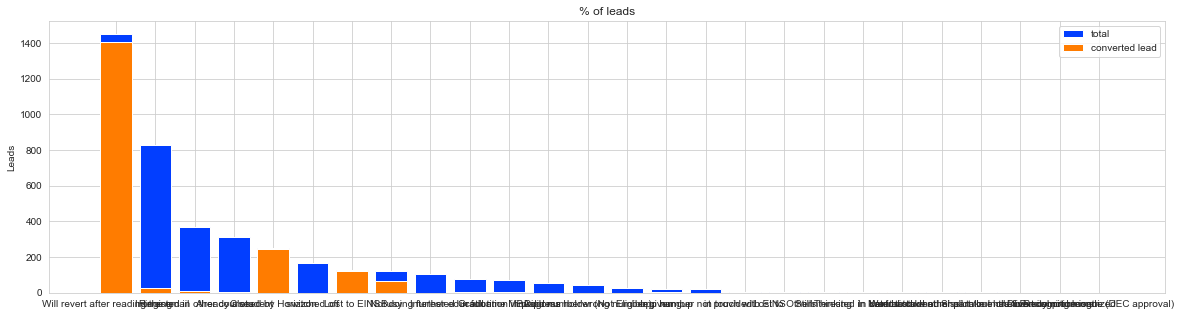

                                   Tags  Converted  total  Converted%
19  Will revert after reading the email       1404   1450   96.827586
14                              Ringing         28    828    3.381643
8           Interested in other courses         11    370    2.972973
0                     Already a student          3    312    0.961538
2                    Closed by Horizzon        247    249   99.196787


In [36]:
univariate_barplots(lead_df, 'Tags', 'Converted', False)

#### Summary of above graph:
* First 2 are very helpful for both seperating the target variable and also imputing missing values

### 25.Country vs response variable

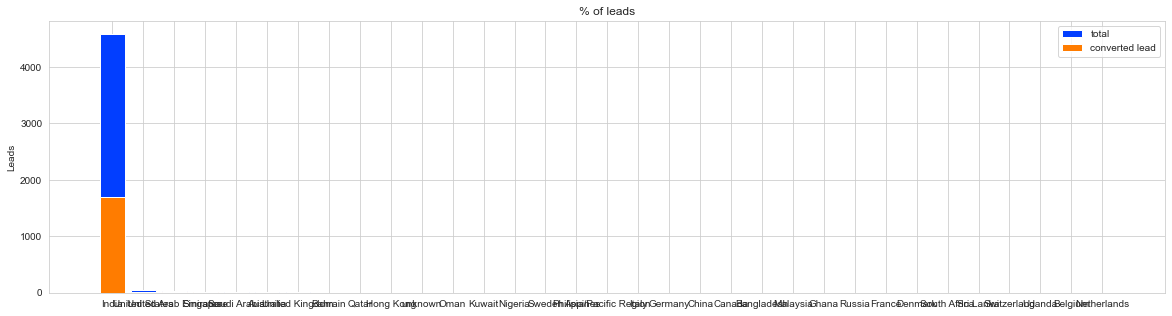

                 Country  Converted  total  Converted%
12                 India       1693   4585   36.924755
31         United States         13     48   27.083333
29  United Arab Emirates         13     38   34.210526
23             Singapore          6     15   40.000000
22          Saudi Arabia          3     14   21.428571


In [37]:
univariate_barplots(lead_df, 'Country', 'Converted', False)

#### Summary of above graph:
* not relevant.

### 26.Specialization vs response variable

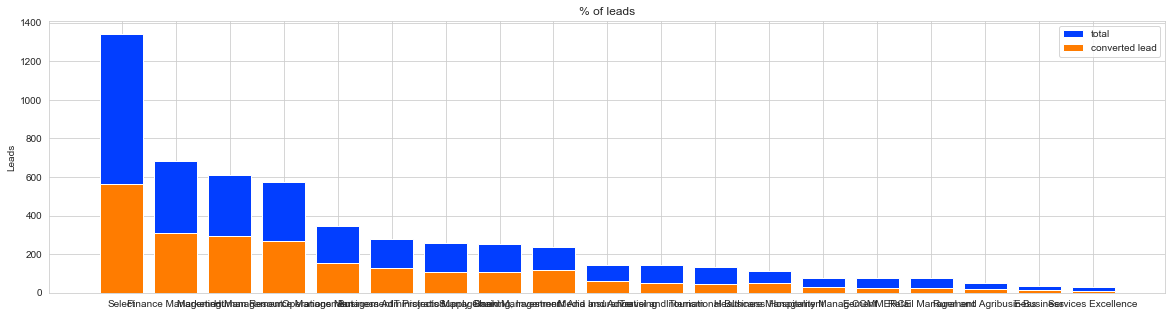

               Specialization  Converted  total  Converted%
15                     Select        566   1342   42.175857
4          Finance Management        312    684   45.614035
10       Marketing Management        297    609   48.768473
7   Human Resource Management        266    577   46.100520
12      Operations Management        154    348   44.252874


In [41]:
univariate_barplots(lead_df, 'Specialization', 'Converted', False)

#### Summary of above graph:
* not relevant.

### 27.Last Notable Activity vs response variable

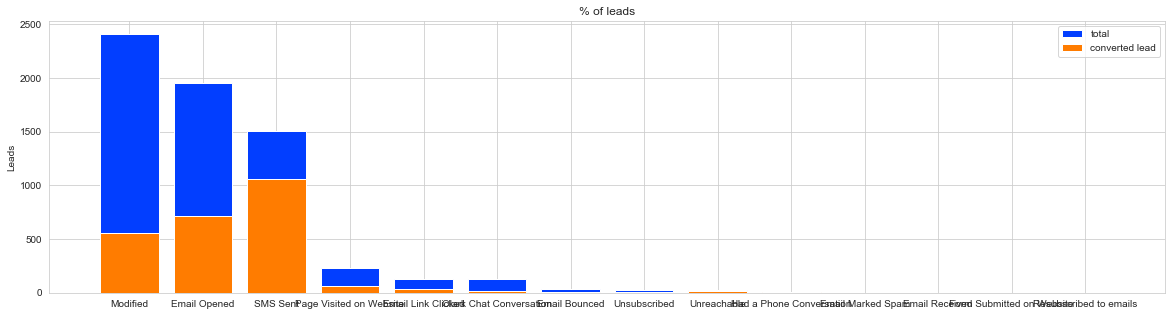

      Last Notable Activity  Converted  total  Converted%
7                  Modified        557   2409   23.121627
3              Email Opened        716   1956   36.605317
11                 SMS Sent       1059   1507   70.272064
9   Page Visited on Website         63    232   27.155172
1        Email Link Clicked         36    127   28.346457


In [42]:
univariate_barplots(lead_df, 'Last Notable Activity', 'Converted', False)

#### Summary of above graph:
* not relevant.

### 28.Last Activity most to you in choosing a course vs response variable

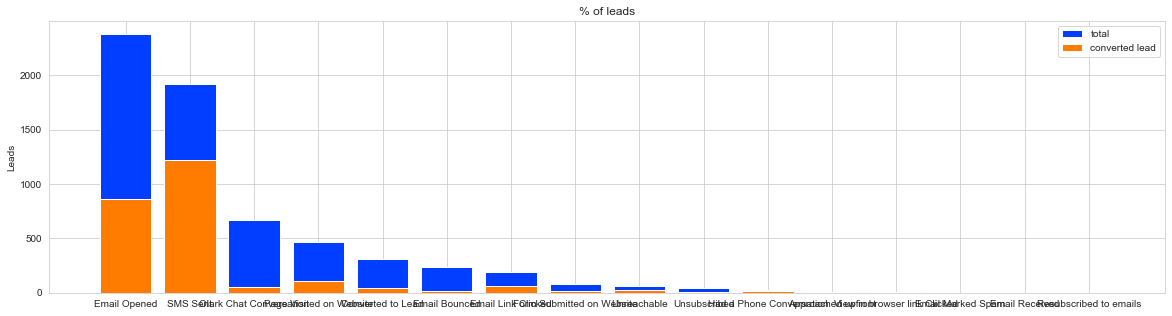

              Last Activity  Converted  total  Converted%
5              Email Opened        858   2380   36.050420
12                 SMS Sent       1218   1923   63.338534
9   Olark Chat Conversation         53    668    7.934132
10  Page Visited on Website        105    466   22.532189
1         Converted to Lead         43    311   13.826367


In [43]:
univariate_barplots(lead_df, 'Last Activity', 'Converted', False)

#### Summary of above graph:
* relevant.

### 28. Lead Source most to you in choosing a course vs response variable

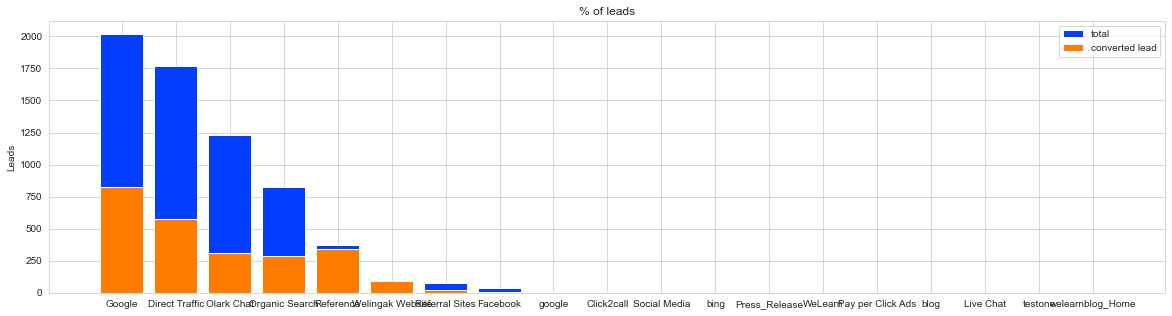

      Lead Source  Converted  total  Converted%
3          Google        827   2019   40.960872
1  Direct Traffic        578   1770   32.655367
5      Olark Chat        310   1229   25.223759
6  Organic Search        290    827   35.066505
9       Reference        338    370   91.351351


In [44]:
univariate_barplots(lead_df, 'Lead Source', 'Converted', False)

#### Summary of above graph:
* relevant.

## Features Table:

## Observing extent of Outlier using Box plots on numerical data:
* on numerical data

### 1.Total Time Spent on Website

In [38]:
print('Medians for Converted and non-Converted lead:')
lead_df[lead_df['Converted'] == 1]['Total Time Spent on Website'].median(),  lead_df[lead_df['Converted'] == 0]['Total Time Spent on Website'].median()

Medians for Converted and non-Converted lead:


(832.0, 181.0)

<AxesSubplot:xlabel='Converted', ylabel='Total Time Spent on Website'>

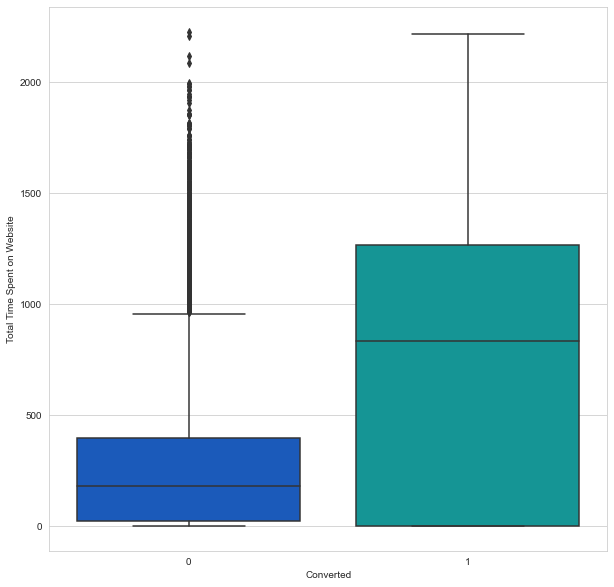

In [39]:
plt.figure(figsize=(10,10))
sns.boxplot(x='Converted', y='Total Time Spent on Website', data=lead_df, palette='winter')

### 2.TotalVisits

In [40]:
print('Medians for Converted and non-Converted lead:')
lead_df[lead_df['Converted'] == 1]['TotalVisits'].median(),  lead_df[lead_df['Converted'] == 0]['TotalVisits'].median()

Medians for Converted and non-Converted lead:


(3.0, 3.0)

<AxesSubplot:xlabel='Converted', ylabel='TotalVisits'>

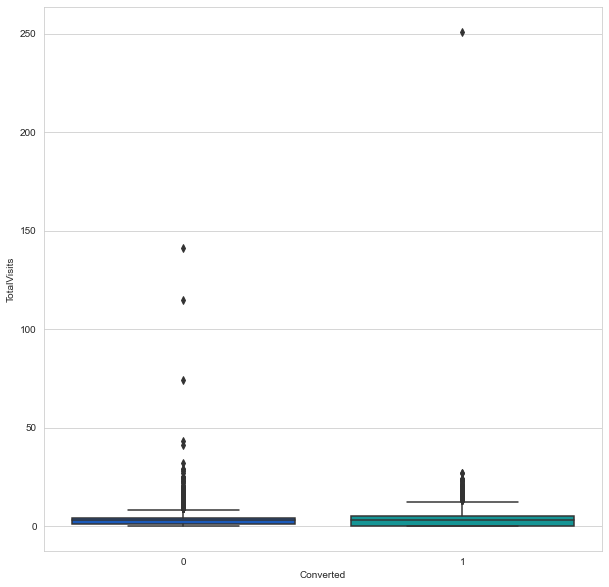

In [41]:
plt.figure(figsize=(10,10))
sns.boxplot(x='Converted', y='TotalVisits', data=lead_df, palette='winter')

### 3. Page Views Per Visit

In [42]:
print('Medians for Converted and non-Converted lead:')
lead_df[lead_df['Converted'] == 1]['Page Views Per Visit'].median(),  lead_df[lead_df['Converted'] == 0]['Page Views Per Visit'].median()

Medians for Converted and non-Converted lead:


(2.0, 2.0)

<AxesSubplot:xlabel='Converted', ylabel='Page Views Per Visit'>

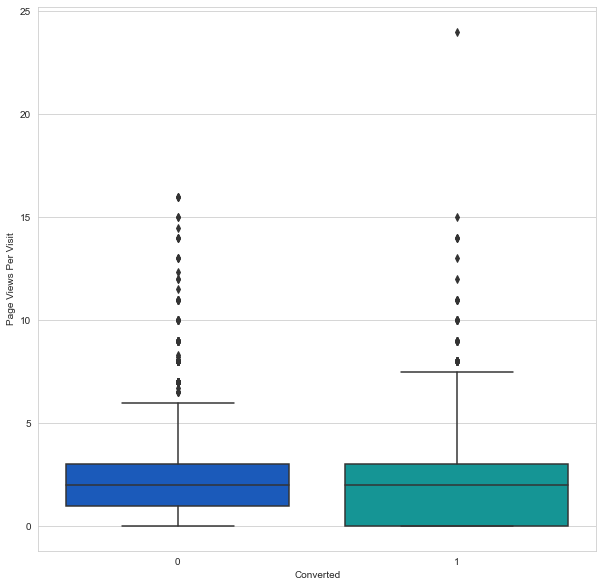

In [43]:
plt.figure(figsize=(10,10))
sns.boxplot(x='Converted', y='Page Views Per Visit', data=lead_df, palette='winter')

### Treating outliers and assigning median values

In [44]:
def outlier_treatment(df):
    '''
    df: input dataframe with outliers in column mentioned inside the function
    (numerical column name, std deviation to assign datapts beyond 3rd std deviation as medians)
    
    '''

    outlier_cols = [('TotalVisits',2), ('Total Time Spent on Website',2), ('Page Views Per Visit',2),
                   ('Asymmetrique Activity Score',2), ('Asymmetrique Profile Score',2)]
    
    for val in outlier_cols:
        if val[0] in df.columns:
            col, z_std = val

            data_mean, data_std = np.mean(df[col]), np.std(df[col])
            cut_off = data_std * z_std
            lower, upper = data_mean - cut_off, data_mean + cut_off

            out_idx = [n for n, x in enumerate(df[col]) if x < lower or x > upper]
            for idx in out_idx:
                df.loc[idx, col] = np.median(df[col])

    return df

## Below are custom impute functions for each categorical feature that has missing values:
* Using Target value missing values are added, incase there is no usefulness of the feature, just random category from the feature is selected

In [45]:
def impute_LS(columns):
    '''
    Imputing by using target variable high seperation
    
    '''
    LS = columns[0]
    target = columns[1]
    if pd.isnull(LS):
        if target == 1:
            return 'Reference'
        else:
            return 'Olark Chat'
    else:
        return LS

def impute_LA(columns):
    '''
    Imputing by using target variable high seperation
    
    '''
    LA = columns[0]
    target = columns[1]
    if pd.isnull(LA):
        if target == 1:
            return 'SMS Sent'
        else:
            return 'Email Opened'
    else:
        return LA

def impute_occ(columns):
    '''
    Imputing by using target variable high seperation
    
    '''
    occ = columns[0]
    target = columns[1]
    if pd.isnull(occ):
        if target == 1:
            return 'Working Professional'
        else:
            return 'Student'
    else:
        return occ


def impute_LQ(columns):
    '''
    Imputing by using target variable high seperation
    
    '''
    LQ = columns[0]
    target = columns[1]
    if pd.isnull(LQ):
        if target == 1:
            return 'High in Relevance'
        else:
            return 'Worst'
    else: 
        return LQ 
    
def impute_tags(columns):
    '''
    Imputing by using target variable high seperation
    
    '''
    tags = columns[0]
    target = columns[1]
    if pd.isnull(tags):
        if target == 1:
            return 'Will revert after reading the email'
        else:
            return 'Worst'
    else: 
        return tags
    

def impute_LP(columns):
    '''
    Imputing by using target variable high seperation
    
    '''
    LP = columns[0]
    target = columns[1]
    if pd.isnull(LP):
        if target == 1:
            return 'Potential Lead'
        else:
            return 'Student of SomeSchool'
    else: 
        return LP

    
def impute_AAI(columns):
    '''
    Imputing by logic: 01.High if target is 1, 02.Medium 0
    
    '''
    AAI = columns[0]
    target = columns[1]
    if pd.isnull(AAI):
        if target == 1:
            return random.choice(['02.Medium', '01.High', '03.Low']) 
        else:
            return '03.Low'
    else:
        return AAI

### Categorical variables cause a problem here as one-hot encoding below categorical values in features will explode the number of features:

In [56]:
def limitCategoricalMedian(df):
    '''
    1. select columns with nan
    2. Get top 6 most occuring values
    3. replace all non top6 occuring values to "column_name.0" this indicates that from this column_name, 
        the non-top6 get this value
    '''
    dict_cat_medians = {'Lead Source': ['Google', 'Direct Traffic', 'Olark Chat', 'Organic Search', 'Reference',
                                        'Welingak Website'],
                         'Last Activity': ['Email Opened', 'SMS Sent', 'Olark Chat Conversation',
                                            'Page Visited on Website', 'Converted to Lead', 'Email Bounced'],
                         'Last Notable Activity': ['Modified', 'Email Opened', 'SMS Sent', 'Page Visited on Website',
                                                    'Email Link Clicked', 'Olark Chat Conversation'],
                         'Tags': ['Will revert after reading the email', 'Worst', 'Ringing',
                                'Interested in other courses', 'Already a student',
                                'Closed by Horizzon']}
    for col in categorical_features:
        if col in dict_cat_medians.keys() and col in df.columns:
            top6 = dict_cat_medians[col]
            df[col] = df[col].apply(lambda x: col+'.0' if str(x) not in top6 else x)
        
    return df

## Feature Selection based on  Univariate Analysis & target variable seperation :

## Preparing Training and Test data:

In [46]:
# All features that doesnt exhibit randomness relation with target variable:

categorical_features = ['Lead Origin', 'Lead Source', 'Last Activity', 'What is your current occupation', 
                       'Lead Quality', 'Lead Profile', 'Asymmetrique Activity Index',
                       'Last Notable Activity',  'Tags'] 

numerical_features =  ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
                         'Asymmetrique Activity Score', 'Asymmetrique Profile Score'] 


In [47]:
select_relevant_features = numerical_features+categorical_features+['Converted']

In [48]:
len(lead_df), len(lead_test)

(6468, 2772)

In [49]:
lead_df_INTER = lead_df[select_relevant_features]
lead_test_INTER = lead_test[select_relevant_features]

In [50]:
if 'Converted' in lead_df_INTER.columns:
    X_train = lead_df_INTER
    y_train = lead_df_INTER['Converted'].values    

if 'Converted' in lead_test_INTER.columns:
    X_test = lead_test_INTER
    y_test = lead_test_INTER['Converted'].values

In [51]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6468, 15) (6468,)
(2772, 15) (2772,)


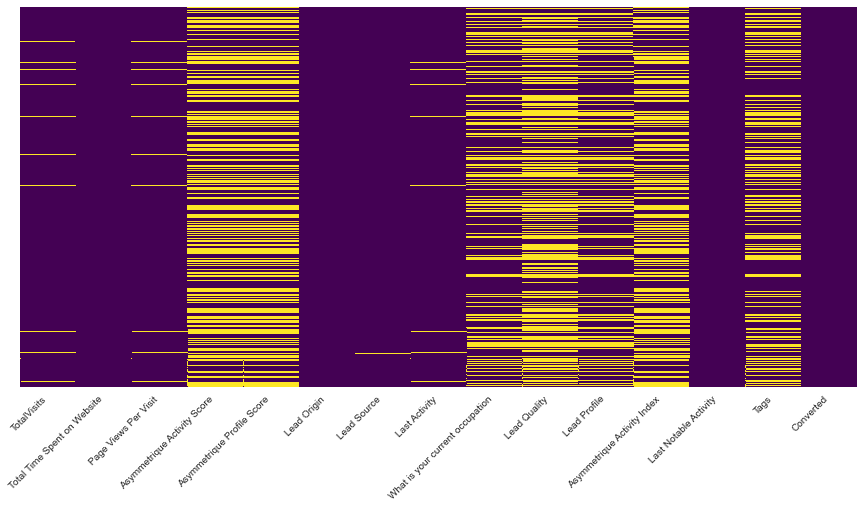

In [52]:
plt.figure(figsize=(15,7))

g = sns.heatmap(X_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')
f = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

### Impute missing values for training data based on training data parameters (median):

In [53]:
X_train['Lead Quality'] = X_train[['Lead Quality', 'Converted']].apply(impute_LQ, axis=1)
X_train['What is your current occupation'] = X_train[['What is your current occupation', 'Converted']].apply(impute_occ, axis=1)
X_train['Tags'] = X_train[['Tags', 'Converted']].apply(impute_tags, axis=1)
X_train['Lead Profile'] = X_train[['Lead Profile', 'Converted']].apply(impute_LP, axis=1)
X_train['Last Activity'] = X_train[['Last Activity', 'Converted']].apply(impute_LA, axis=1)
X_train['Lead Source'] = X_train[['Lead Source', 'Converted']].apply(impute_LS, axis=1)
X_train['Asymmetrique Activity Index'] = X_train[['Asymmetrique Activity Index', 'Converted']].apply(impute_AAI, axis=1)


### Treating outliers using remove values beyond 2 standard deviations:  

In [54]:
X_train = outlier_treatment(X_train)

### Limit categorical features to have only 6 unique values for each:

In [57]:
X_train = limitCategoricalMedian(X_train)

In [58]:
X_train['TotalVisits'].fillna(X_train['TotalVisits'].median(), inplace=True)
X_train['Page Views Per Visit'].fillna(X_train['Page Views Per Visit'].median(), inplace=True)
X_train['Asymmetrique Activity Score'].fillna(X_train['Asymmetrique Activity Score'].median(), inplace=True)
X_train['Asymmetrique Profile Score'].fillna(X_train['Asymmetrique Profile Score'].median(), inplace=True)

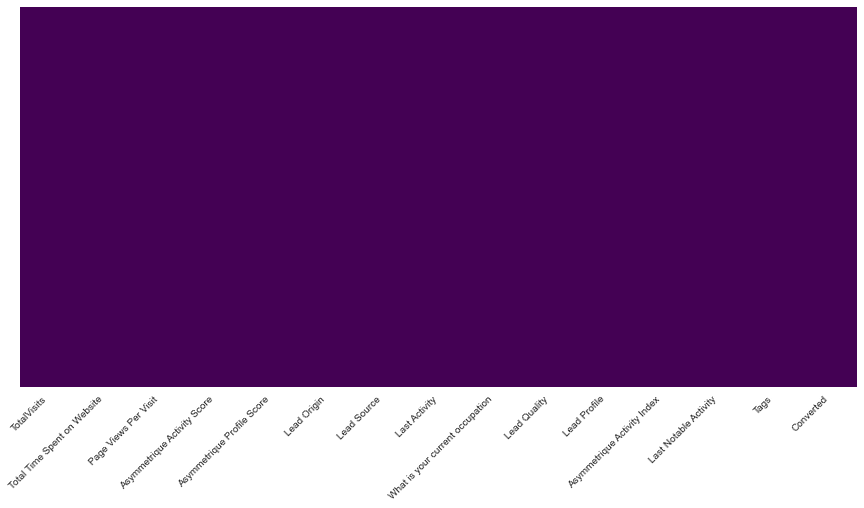

In [59]:
plt.figure(figsize=(15,7))

g = sns.heatmap(X_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')
f = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

#### Remaining missing vals are numerical handled by imputing pipeline(median) , Training data is ready!

In [60]:
if 'Converted' in lead_df_INTER.columns:
    del X_train['Converted']
    

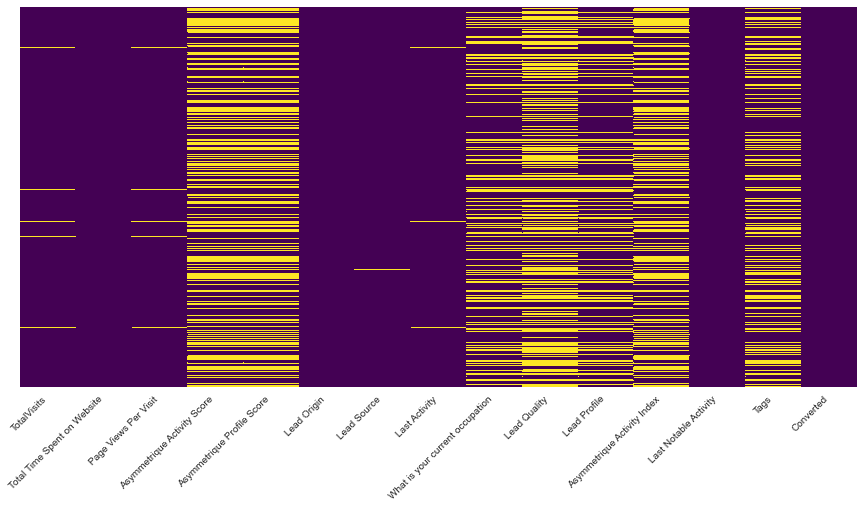

In [61]:
plt.figure(figsize=(15,7))

g = sns.heatmap(X_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')
f = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

### Impute missing values for test data based on training data parameters (median):

In [62]:

X_test['Lead Quality'] = X_test[['Lead Quality', 'Converted']].apply(impute_LQ, axis=1)
X_test['What is your current occupation'] = X_test[['What is your current occupation', 'Converted']].apply(impute_occ, axis=1)
X_test['Tags'] = X_test[['Tags', 'Converted']].apply(impute_tags, axis=1)
X_test['Lead Profile'] = X_test[['Lead Profile', 'Converted']].apply(impute_LP, axis=1)
X_test['Last Activity'] = X_test[['Last Activity', 'Converted']].apply(impute_LA, axis=1)
X_test['Lead Source'] = X_test[['Lead Source', 'Converted']].apply(impute_LS, axis=1)
X_test['Asymmetrique Activity Index'] = X_test[['Asymmetrique Activity Index', 'Converted']].apply(impute_AAI, axis=1)


### Treating outliers using remove values beyond 2 standard deviations:  

In [63]:
X_test = outlier_treatment(X_test)

### Limit categorical features to have only 6 unique values for each:

In [64]:
X_test = limitCategoricalMedian(X_test)

In [65]:
X_test['TotalVisits'].fillna(X_test['TotalVisits'].median(), inplace=True)
X_test['Page Views Per Visit'].fillna(X_test['Page Views Per Visit'].median(), inplace=True)
X_test['Asymmetrique Activity Score'].fillna(X_test['Asymmetrique Activity Score'].median(), inplace=True)
X_test['Asymmetrique Profile Score'].fillna(X_test['Asymmetrique Profile Score'].median(), inplace=True)

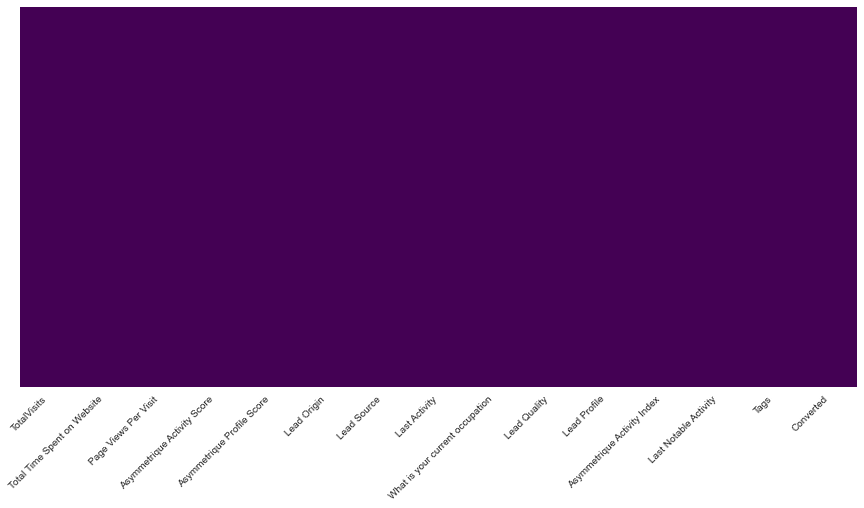

In [66]:
plt.figure(figsize=(15,7))

g = sns.heatmap(X_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')
f = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

#### Test data is ready!

# Backward feature selection using logistic regression coefficients:

## Pipeline to vectorize: 
a0) Impute missing values by median
a) Categorical  features
b) Numerical  features

In [67]:
scaleNumericalfeatures = Pipeline([('std', StandardScaler()), ('imputer', SimpleImputer(strategy="median")), ])

full_pipeline = ColumnTransformer([("NumericalFeatures", scaleNumericalfeatures, 
                                    numerical_features),
                                   ("CategoricalFeatures", OneHotEncoder(handle_unknown='ignore'), 
                                    categorical_features),])

In [68]:

if 'Converted' in lead_test_INTER.columns:
    del X_test['Converted']

In [69]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6468, 14) (6468,)
(2772, 14) (2772,)


In [70]:
X_train_ = X_train
y_train_ = y_train
X_test_ = X_test
y_test_ = y_test

## Pipeline to vectorize: 
a) Categorical  features
b) Numerical  features
c) Adding gridsearch for logistic regression to find best learning rate

In [71]:
param_grid = {"alpha":[0.0001, 0.001, 0.01, 0.1]} # This alpha is the learning rate in the update function

Lr = linear_model.SGDClassifier(loss='log', random_state=42)


grid_search = GridSearchCV(Lr, param_grid, cv = 5, scoring='roc_auc')
grid_pipeline = Pipeline(steps=[('preprocessor', full_pipeline), ('gridSearch', grid_search)])
grid_pipeline.fit(X_train_, y_train_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('NumericalFeatures',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['TotalVisits',
                                                   'Total Time Spent on '
                                                   'Website',
                                                   'Page Views Per Visit',
                                                   'Asymmetrique Activity '
                                                   'Score',
                                                   'Asymmetrique Profile '
                                                   'Score']),
    

## Pipeline to vectorize: 
a) Categorical  features
b) Numerical  features
c) Adding logistic regression as a final part of the pipeline

In [72]:
Lr = linear_model.SGDClassifier(loss='log', random_state=42, alpha=grid_pipeline['gridSearch'].best_params_['alpha'])
trained_pipeline = Pipeline(steps=[('preprocessor', full_pipeline), ('log-reg classifier', Lr)])
trained_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('NumericalFeatures',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['TotalVisits',
                                                   'Total Time Spent on '
                                                   'Website',
                                                   'Page Views Per Visit',
                                                   'Asymmetrique Activity '
                                                   'Score',
                                                   'Asymmetrique Profile '
                                                   'Score']),
    

In [73]:
np.set_printoptions(suppress=True)

In [74]:
all_feats = numerical_features + trained_pipeline['preprocessor'].transformers_[1][1].get_feature_names(categorical_features).tolist()

In [75]:
coefs = trained_pipeline['log-reg classifier'].coef_.tolist()[0]

In [76]:
trained_pipeline['log-reg classifier'].intercept_

array([-0.12636814])

In [77]:
interpret_log_reg = {k:v for k,v in zip(all_feats, coefs) }
interpret_log_reg

{'TotalVisits': -0.20423873172326054,
 'Total Time Spent on Website': 0.7620945605789953,
 'Page Views Per Visit': -0.4390097166127029,
 'Asymmetrique Activity Score': 0.09149187494838708,
 'Asymmetrique Profile Score': 0.025700047434406355,
 'Lead Origin_API': 0.16777865237034423,
 'Lead Origin_Landing Page Submission': 0.027851130631768174,
 'Lead Origin_Lead Add Form': -0.2560484716884698,
 'Lead Origin_Lead Import': -0.3528913898997673,
 'Lead Origin_Quick Add Form': 0.058828821965060216,
 'Lead Source_Direct Traffic': -0.23128480902588183,
 'Lead Source_Google': -0.11773248499101387,
 'Lead Source_Lead Source.0': -0.35435149209543554,
 'Lead Source_Olark Chat': -0.02611325515014808,
 'Lead Source_Organic Search': -0.5108166528614853,
 'Lead Source_Reference': 0.14148624835222215,
 'Lead Source_Welingak Website': 0.7443311891506786,
 'Last Activity_Converted to Lead': -0.1525267296580055,
 'Last Activity_Email Bounced': -1.3082569586482364,
 'Last Activity_Email Opened': 0.26550884

<font color='blue'>Mathematical interpretation:
    
LOG ODDS = intercept-value + coeff1 * numeric1 + coeff2 * numeric2 + coeff3 * numeric3 + ....
where LOG ODDS = log(p/1-p)   p - probability of success (converted)         </font>        

#### Predictions:

In [78]:
y_pred_train_proba = trained_pipeline.predict_proba(X_train)[:, 1]
y_pred_test_proba = trained_pipeline.predict_proba(X_test)[:, 1]
y_pred_train_proba

array([0.00006758, 0.00819391, 0.89810422, ..., 0.99988415, 0.00001116,
       0.89706481])

In [79]:
y_train

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

#### Setting threshold to predicted probabilities as 0.5

In [80]:
y_train_pred = [1 if x >= 0.50 else 0 for x in y_pred_train_proba]
y_test_pred = [1 if x >= 0.50 else 0 for x in y_pred_test_proba]

### Training data confusion matrix:

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

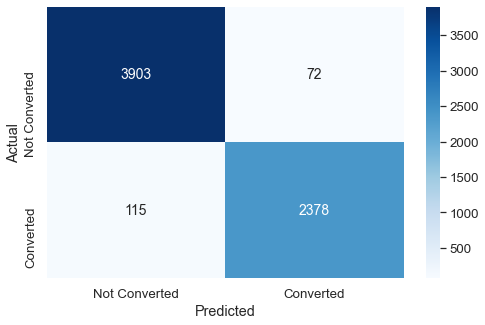

In [81]:

conf = confusion_matrix(y_train, y_train_pred)
df_cm = pd.DataFrame(conf, columns=['Not Converted' , 'Converted'], index = ['Not Converted', 'Converted'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,5))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 14} , fmt='d')

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

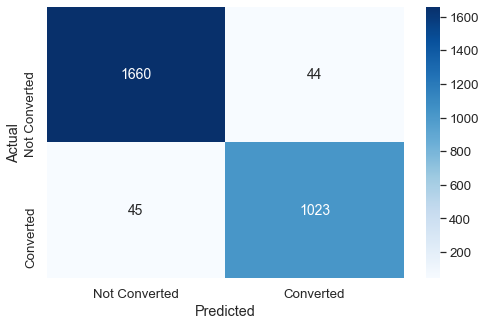

In [82]:

conf = confusion_matrix(y_test, y_test_pred)
df_cm = pd.DataFrame(conf, columns=['Not Converted' , 'Converted'], index = ['Not Converted', 'Converted'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,5))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 14} , fmt='d')

In [83]:
roc_auc_score(y_train, y_pred_train_proba)

0.9960932119368194

In [84]:
roc_auc_score(y_test, y_pred_test_proba)

0.993679225791704

In [85]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [198]:
m.style.use('seaborn-bright')

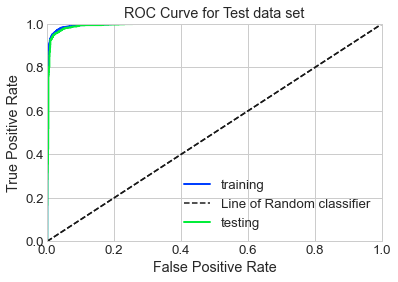

In [93]:
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_pred_train_proba)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_pred_test_proba)


plot_roc_curve(train_fpr1, train_tpr1)
plt.title("ROC Curve for Train data set")

plot_roc_curve(test_fpr1, test_tpr1)
plt.title("ROC Curve for Test data set")
plt.legend(['training', 'Line of Random classifier', 'testing'])

### Histogram of predicted probabilities: This will help us identify if the model is confident or just a good guesser!

<AxesSubplot:>

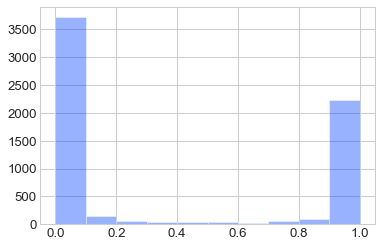

In [94]:
sns.distplot(y_pred_train_proba, kde=False)

<AxesSubplot:>

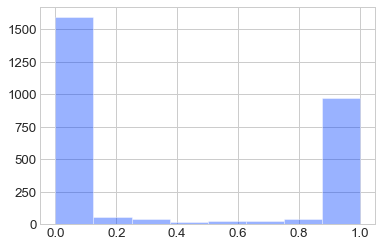

In [95]:
sns.distplot(y_pred_test_proba, kde=False)


#### Summary:
* A Histogram of predicted probabilities with 2 peeks are the 0 and 1 ends indicate a confident model in its predictions.

### View top 25 features:

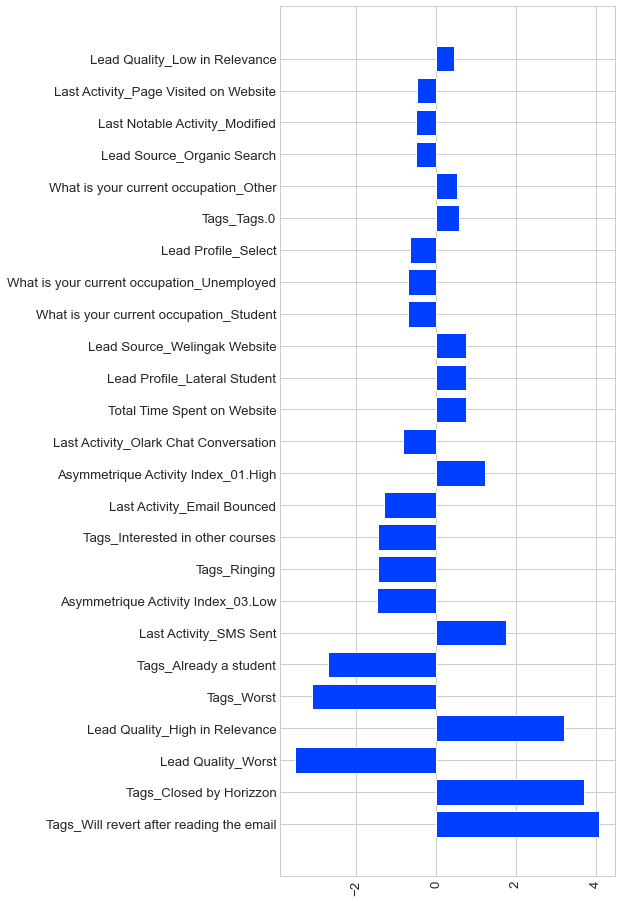

In [96]:
top = 25
dict_key = interpret_log_reg.keys()
top_features=sorted(interpret_log_reg, key=lambda dict_key: abs(interpret_log_reg[dict_key]), reverse=True)[:top]
top_features = {k:interpret_log_reg[k] for k in top_features}
names = list(top_features.keys())
values = list(top_features.values())
plt.figure(figsize=(6,16))
plt.barh(range(len(top_features)), values, tick_label=names)
plt.xticks(rotation = 90)
plt.show()

In [97]:
top_features

{'Tags_Will revert after reading the email': 4.092945726689245,
 'Tags_Closed by Horizzon': 3.718075949458556,
 'Lead Quality_Worst': -3.534312912114145,
 'Lead Quality_High in Relevance': 3.2170043025262918,
 'Tags_Worst': -3.1153167531019434,
 'Tags_Already a student': -2.7182322322067365,
 'Last Activity_SMS Sent': 1.7601155643246238,
 'Asymmetrique Activity Index_03.Low': -1.4728788964129016,
 'Tags_Ringing': -1.452015604455205,
 'Tags_Interested in other courses': -1.4432372125324098,
 'Last Activity_Email Bounced': -1.3082569586482364,
 'Asymmetrique Activity Index_01.High': 1.224485994735021,
 'Last Activity_Olark Chat Conversation': -0.8243835885428812,
 'Total Time Spent on Website': 0.7620945605789953,
 'Lead Profile_Lateral Student': 0.7580896442757132,
 'Lead Source_Welingak Website': 0.7443311891506786,
 'What is your current occupation_Student': -0.7157240273369785,
 'What is your current occupation_Unemployed': -0.7017080131698098,
 'Lead Profile_Select': -0.660452989156

In [98]:
top_derived_features = {x.split('_')[0] for x in list(top_features.keys())}
top_derived_features

{'Asymmetrique Activity Index',
 'Last Activity',
 'Last Notable Activity',
 'Lead Profile',
 'Lead Quality',
 'Lead Source',
 'Tags',
 'Total Time Spent on Website',
 'What is your current occupation'}

* useful for next step


In [99]:
top_derived_features=list(top_derived_features)
top_derived_features

['Asymmetrique Activity Index',
 'Last Notable Activity',
 'What is your current occupation',
 'Last Activity',
 'Lead Profile',
 'Lead Source',
 'Total Time Spent on Website',
 'Lead Quality',
 'Tags']

In [110]:
categorical_features = ['Asymmetrique Activity Index',
                         'Last Notable Activity',
                         'What is your current occupation',
                         'Last Activity',
                         'Lead Profile',
                         'Lead Source',
                         'Lead Quality',
                         'Tags']

numerical_features = ['Total Time Spent on Website']

## Preparing data temporarily for removing multicollinearity via Variance Inflation Factors:

In [111]:
temp_VIF = lead_df[top_derived_features+['Converted']]

In [112]:
temp_VIF = temp_VIF.fillna(temp_VIF.median())

In [113]:
temp_VIF['Lead Quality'] = temp_VIF[['Lead Quality', 'Converted']].apply(impute_LQ, axis=1)
temp_VIF['What is your current occupation'] = temp_VIF[['What is your current occupation', 'Converted']].apply(impute_occ, axis=1)
temp_VIF['Tags'] = temp_VIF[['Tags', 'Converted']].apply(impute_tags, axis=1)
temp_VIF['Lead Profile'] = temp_VIF[['Lead Profile', 'Converted']].apply(impute_LP, axis=1)
temp_VIF['Last Activity'] = temp_VIF[['Last Activity', 'Converted']].apply(impute_LA, axis=1)
temp_VIF['Lead Source'] = temp_VIF[['Lead Source', 'Converted']].apply(impute_LS, axis=1)
temp_VIF['Asymmetrique Activity Index'] = temp_VIF[['Asymmetrique Activity Index', 'Converted']].apply(impute_AAI, axis=1)


In [114]:
def displayVIF(df):
    '''
    Displays VIF
    '''

    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif

In [115]:
cat_feat_vals = []
for x in categorical_features:
    cat_feat_vals.append(len(temp_VIF[x].unique()))
    print(x,' has',len(temp_VIF[x].unique()), 'unique categories')

Asymmetrique Activity Index  has 3 unique categories
Last Notable Activity  has 14 unique categories
What is your current occupation  has 6 unique categories
Last Activity  has 16 unique categories
Lead Profile  has 6 unique categories
Lead Source  has 20 unique categories
Lead Quality  has 5 unique categories
Tags  has 27 unique categories


In [118]:
print('Lets select ', 6, ' as top number of values for each feature')

Lets select  6  as top number of values for each feature


In [119]:
temp_VIF = limitCategoricalMedian(temp_VIF)


In [120]:
for x in categorical_features:
    print(x,' has',len(temp_VIF[x].unique()), 'unique categories')

Asymmetrique Activity Index  has 3 unique categories
Last Notable Activity  has 7 unique categories
What is your current occupation  has 6 unique categories
Last Activity  has 7 unique categories
Lead Profile  has 6 unique categories
Lead Source  has 7 unique categories
Lead Quality  has 5 unique categories
Tags  has 7 unique categories


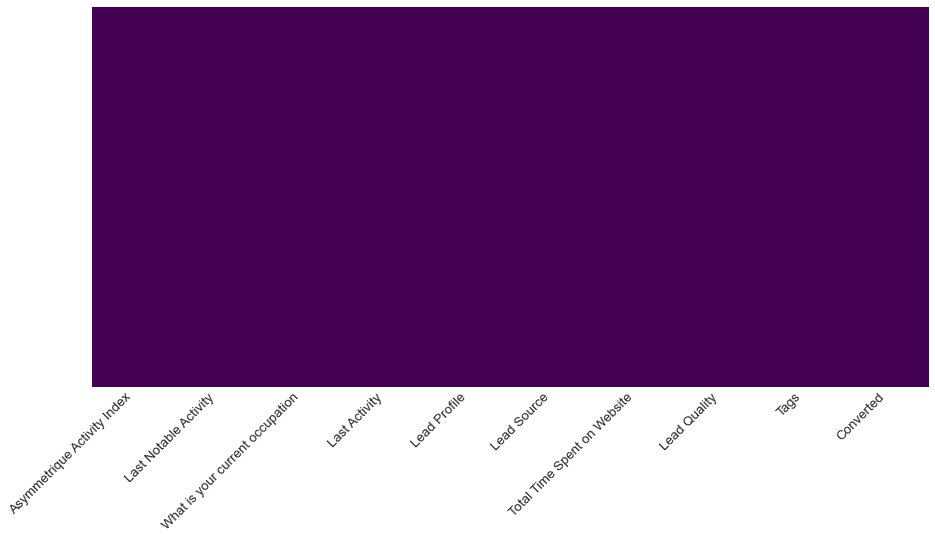

In [121]:
plt.figure(figsize=(15,7))

g = sns.heatmap(temp_VIF.isnull(), yticklabels=False, cbar=False, cmap='viridis')
f = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

In [143]:
one_hot_categories = pd.get_dummies(temp_VIF[categorical_features])
num_temp_VIF = temp_VIF[numerical_features]

In [145]:
for x in range(0, one_hot_categories.shape[1], 9):
    print(x)
    categ_temp_VIF = one_hot_categories.iloc[:,0+x:9+x]
    
    print(displayVIF(pd.concat([categ_temp_VIF, num_temp_VIF], axis=1)))

0
                                       variables       VIF
0            Asymmetrique Activity Index_01.High  1.626029
1          Asymmetrique Activity Index_02.Medium  3.370166
2             Asymmetrique Activity Index_03.Low  2.711972
3       Last Notable Activity_Email Link Clicked  1.064242
4             Last Notable Activity_Email Opened  1.630182
5  Last Notable Activity_Last Notable Activity.0  1.054032
6                 Last Notable Activity_Modified  1.676094
7  Last Notable Activity_Olark Chat Conversation  1.077218
8  Last Notable Activity_Page Visited on Website  1.112994
9                    Total Time Spent on Website  1.042461
9
                                           variables       VIF
0                     Last Notable Activity_SMS Sent  1.122461
1        What is your current occupation_Businessman  1.001580
2          What is your current occupation_Housewife  1.002218
3              What is your current occupation_Other  1.002073
4            What is your curren

### Remove features with high VIF score:

In [146]:
None

# <font color='red'>Using top features and building final model:</font>


In [157]:
corrected_features = top_derived_features+['Converted']

In [158]:
lead_df_INTER = lead_df[corrected_features]
lead_test_INTER = lead_test[corrected_features]

In [159]:
if 'Converted' in lead_df_INTER.columns:
    X_train = lead_df_INTER
    y_train = lead_df_INTER['Converted'].values    

if 'Converted' in lead_test_INTER.columns:
    X_test = lead_test_INTER
    y_test = lead_test_INTER['Converted'].values

In [160]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6468, 10) (6468,)
(2772, 10) (2772,)


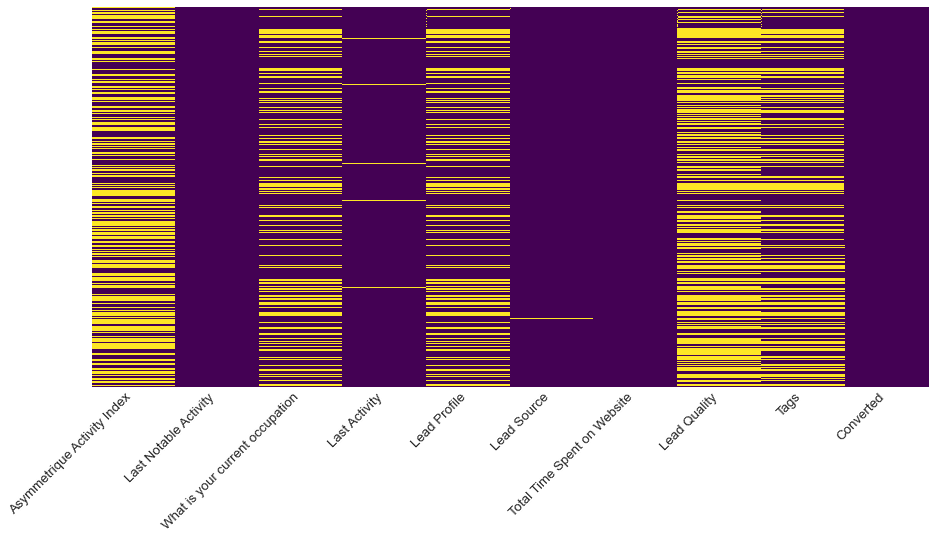

In [161]:
plt.figure(figsize=(15,7))

g = sns.heatmap(X_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')
f = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

### Impute missing values for training data based on training data parameters (median):

In [162]:
X_train['Lead Quality'] = X_train[['Lead Quality', 'Converted']].apply(impute_LQ, axis=1)
X_train['What is your current occupation'] = X_train[['What is your current occupation', 'Converted']].apply(impute_occ, axis=1)
X_train['Tags'] = X_train[['Tags', 'Converted']].apply(impute_tags, axis=1)
X_train['Lead Profile'] = X_train[['Lead Profile', 'Converted']].apply(impute_LP, axis=1)
X_train['Last Activity'] = X_train[['Last Activity', 'Converted']].apply(impute_LA, axis=1)
X_train['Lead Source'] = X_train[['Lead Source', 'Converted']].apply(impute_LS, axis=1)
X_train['Asymmetrique Activity Index'] = X_train[['Asymmetrique Activity Index', 'Converted']].apply(impute_AAI, axis=1)


### Treating outliers using remove values beyond 2 standard deviations:  

In [163]:
X_train = outlier_treatment(X_train)

### Limit categorical features to have only 6 unique values for each:

In [164]:
X_train = limitCategoricalMedian(X_train)

In [165]:
# X_train['TotalVisits'].fillna(X_train['TotalVisits'].median(), inplace=True)
# X_train['Page Views Per Visit'].fillna(X_train['Page Views Per Visit'].median(), inplace=True)
# X_train['Asymmetrique Activity Score'].fillna(X_train['Asymmetrique Activity Score'].median(), inplace=True)
# X_train['Asymmetrique Profile Score'].fillna(X_train['Asymmetrique Profile Score'].median(), inplace=True)

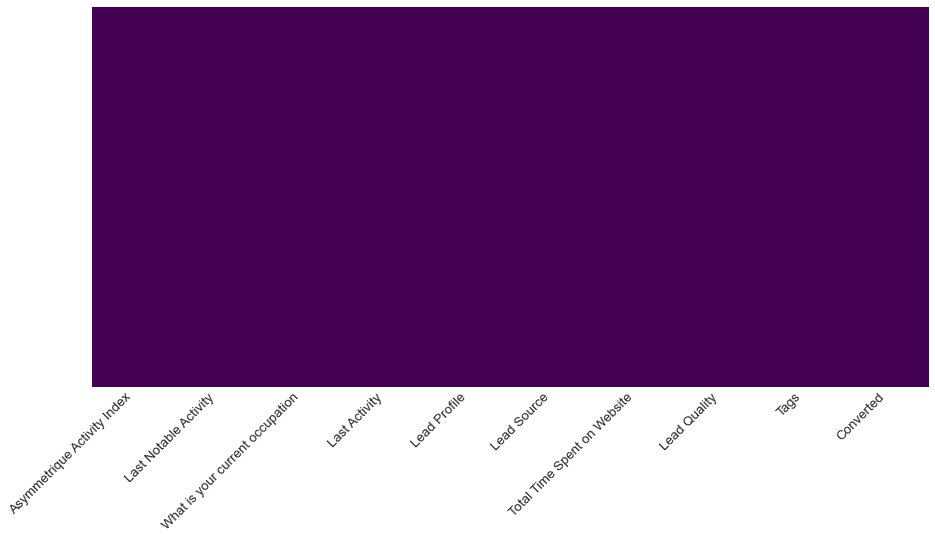

In [166]:
plt.figure(figsize=(15,7))

g = sns.heatmap(X_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')
f = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

#### Remaining missing vals are numerical handled by imputing pipeline(median) , Training data is ready!

In [167]:
if 'Converted' in lead_df_INTER.columns:
    del X_train['Converted']
    

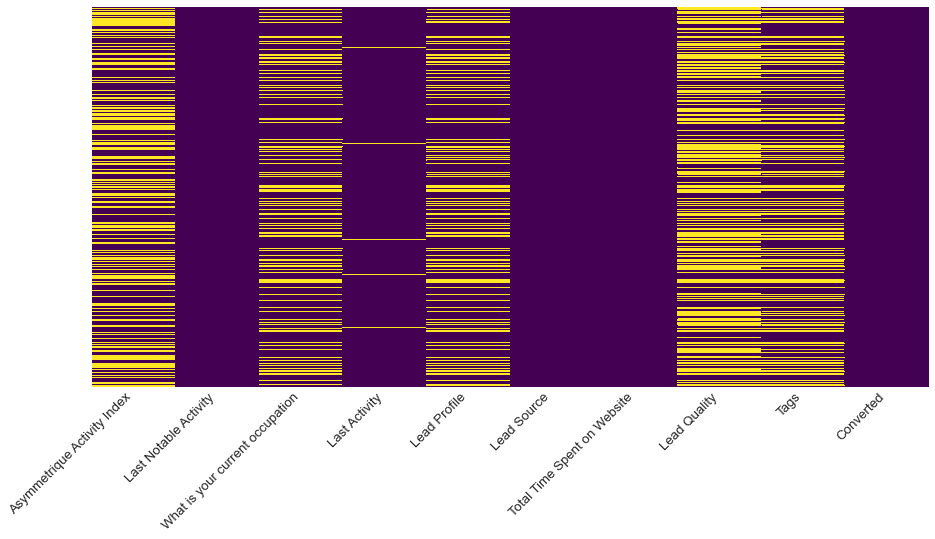

In [168]:
plt.figure(figsize=(15,7))

g = sns.heatmap(X_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')
f = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

### Impute missing values for test data based on training data parameters (median):

In [169]:

X_test['Lead Quality'] = X_test[['Lead Quality', 'Converted']].apply(impute_LQ, axis=1)
X_test['What is your current occupation'] = X_test[['What is your current occupation', 'Converted']].apply(impute_occ, axis=1)
X_test['Tags'] = X_test[['Tags', 'Converted']].apply(impute_tags, axis=1)
X_test['Lead Profile'] = X_test[['Lead Profile', 'Converted']].apply(impute_LP, axis=1)
X_test['Last Activity'] = X_test[['Last Activity', 'Converted']].apply(impute_LA, axis=1)
X_test['Lead Source'] = X_test[['Lead Source', 'Converted']].apply(impute_LS, axis=1)
X_test['Asymmetrique Activity Index'] = X_test[['Asymmetrique Activity Index', 'Converted']].apply(impute_AAI, axis=1)


### Treating outliers using remove values beyond 2 standard deviations:  

In [170]:
X_test = outlier_treatment(X_test)

### Limit categorical features to have only 6 unique values for each:

In [171]:
X_test = limitCategoricalMedian(X_test)

In [172]:
# X_test['TotalVisits'].fillna(X_test['TotalVisits'].median(), inplace=True)
# X_test['Page Views Per Visit'].fillna(X_test['Page Views Per Visit'].median(), inplace=True)
# X_test['Asymmetrique Activity Score'].fillna(X_test['Asymmetrique Activity Score'].median(), inplace=True)
# X_test['Asymmetrique Profile Score'].fillna(X_test['Asymmetrique Profile Score'].median(), inplace=True)

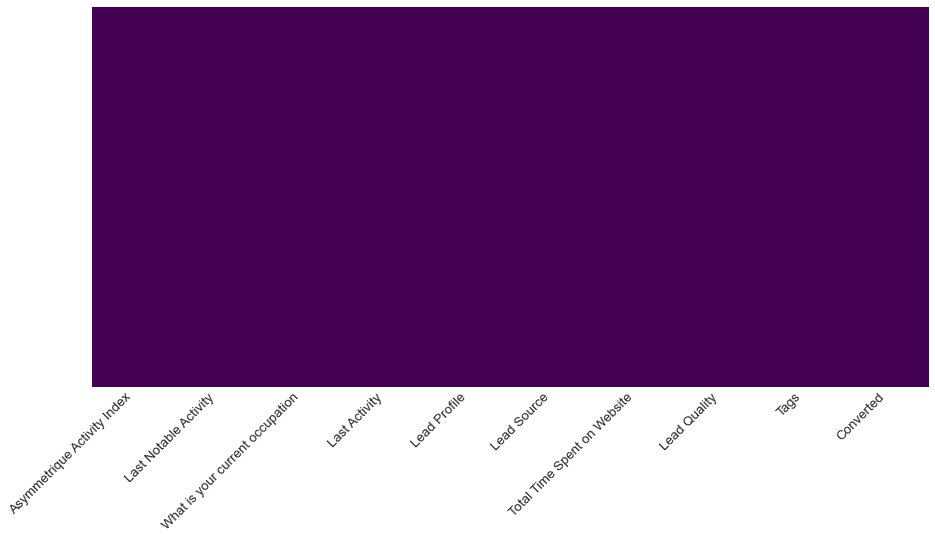

In [173]:
plt.figure(figsize=(15,7))

g = sns.heatmap(X_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')
f = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

#### Test data is ready!

## Pipeline to vectorize: 
a0) Impute missing values by median
a) Categorical  features
b) Numerical  features

In [175]:
scaleNumericalfeatures = Pipeline([('std', StandardScaler()), ('imputer', SimpleImputer(strategy="median")), ])

full_pipeline = ColumnTransformer([("NumericalFeatures", scaleNumericalfeatures, 
                                    numerical_features),
                                   ("CategoricalFeatures", OneHotEncoder(handle_unknown='ignore'), 
                                    categorical_features),])

In [176]:

if 'Converted' in lead_test_INTER.columns:
    del X_test['Converted']

In [177]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6468, 9) (6468,)
(2772, 9) (2772,)


## Pipeline to vectorize: 
a) Categorical  features
b) Numerical  features
c) Adding logistic regression as a final part of the pipeline

In [178]:
param_grid = {"alpha":[0.0001, 0.001, 0.01, 0.1]} # This alpha is the learning rate in the update function

Lr = linear_model.SGDClassifier(loss='log', random_state=42)


grid_search = GridSearchCV(Lr, param_grid, cv = 5, scoring='roc_auc')
grid_pipeline = Pipeline(steps=[('preprocessor', full_pipeline), ('gridSearch', grid_search)])
grid_pipeline.fit(X_train_, y_train_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('NumericalFeatures',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Total Time Spent on '
                                                   'Website']),
                                                 ('CategoricalFeatures',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Asymmetrique Activity '
                                                   'Index',
                                                   'Last Notable Activity',
                                         

In [179]:
Lr = linear_model.SGDClassifier(loss='log', random_state=42, alpha=grid_pipeline['gridSearch'].best_params_['alpha'])
trained_pipeline = Pipeline(steps=[('preprocessor', full_pipeline), ('log-reg classifier', Lr)])
trained_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('NumericalFeatures',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Total Time Spent on '
                                                   'Website']),
                                                 ('CategoricalFeatures',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Asymmetrique Activity '
                                                   'Index',
                                                   'Last Notable Activity',
                                         

In [180]:
np.set_printoptions(suppress=True)

In [183]:
all_feats = numerical_features + trained_pipeline['preprocessor'].transformers_[1][1].get_feature_names(categorical_features).tolist()

In [184]:
coefs = trained_pipeline['log-reg classifier'].coef_.tolist()[0]

In [185]:
trained_pipeline['log-reg classifier'].intercept_

array([-0.07513709])

In [186]:
interpret_log_reg = {k:v for k,v in zip(all_feats, coefs) }
interpret_log_reg

{'Total Time Spent on Website': 0.515322233408073,
 'Asymmetrique Activity Index_01.High': 1.4537653302182552,
 'Asymmetrique Activity Index_02.Medium': -0.13110760290565646,
 'Asymmetrique Activity Index_03.Low': -1.5167633253131145,
 'Last Notable Activity_Email Link Clicked': 0.19165611476211816,
 'Last Notable Activity_Email Opened': 0.19946857971999374,
 'Last Notable Activity_Last Notable Activity.0': -0.1986788326937672,
 'Last Notable Activity_Modified': -0.624487252762237,
 'Last Notable Activity_Olark Chat Conversation': 0.35259500947554073,
 'Last Notable Activity_Page Visited on Website': 0.42364464919740696,
 'Last Notable Activity_SMS Sent': -0.5383038656995537,
 'What is your current occupation_Businessman': 0.1260426298067414,
 'What is your current occupation_Housewife': 0.28871812395190394,
 'What is your current occupation_Other': 0.023837879908156497,
 'What is your current occupation_Student': -0.5103875987733237,
 'What is your current occupation_Unemployed': -0.4

### View top 25 features:

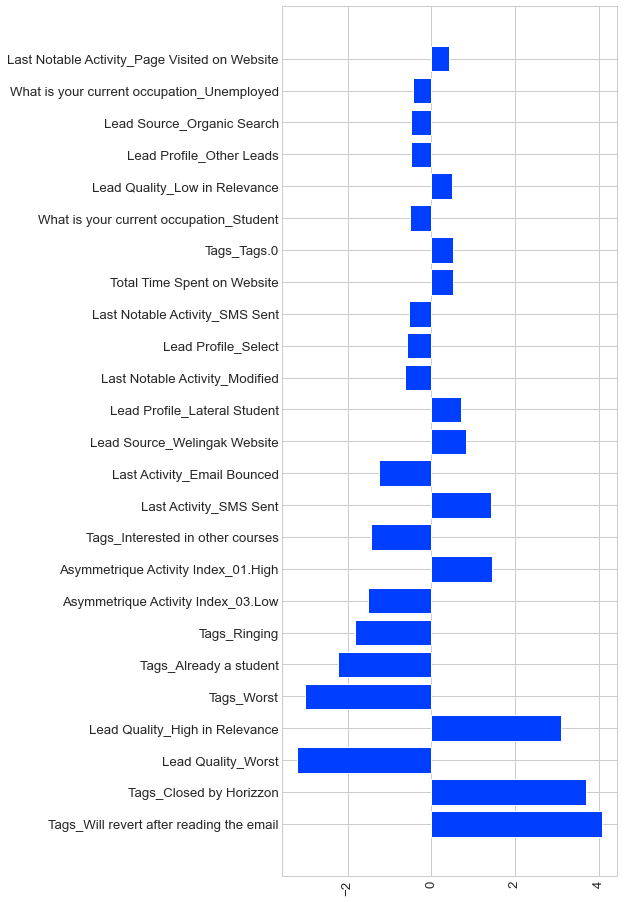

In [187]:
top = 25
dict_key = interpret_log_reg.keys()
top_features=sorted(interpret_log_reg, key=lambda dict_key: abs(interpret_log_reg[dict_key]), reverse=True)[:top]
top_features = {k:interpret_log_reg[k] for k in top_features}
names = list(top_features.keys())
values = list(top_features.values())
plt.figure(figsize=(6,16))
plt.barh(range(len(top_features)), values, tick_label=names)
plt.xticks(rotation = 90)
plt.show()

In [188]:
top_features

{'Tags_Will revert after reading the email': 4.075143353769864,
 'Tags_Closed by Horizzon': 3.709015933294939,
 'Lead Quality_Worst': -3.2004713211119045,
 'Lead Quality_High in Relevance': 3.0898722780146888,
 'Tags_Worst': -3.008756613503773,
 'Tags_Already a student': -2.23118412174545,
 'Tags_Ringing': -1.8153189511844983,
 'Asymmetrique Activity Index_03.Low': -1.5167633253131145,
 'Asymmetrique Activity Index_01.High': 1.4537653302182552,
 'Tags_Interested in other courses': -1.4381675300275651,
 'Last Activity_SMS Sent': 1.435199127585599,
 'Last Activity_Email Bounced': -1.2518772835792056,
 'Lead Source_Welingak Website': 0.8224725069890315,
 'Lead Profile_Lateral Student': 0.7143159978944994,
 'Last Notable Activity_Modified': -0.624487252762237,
 'Lead Profile_Select': -0.5718055302059749,
 'Last Notable Activity_SMS Sent': -0.5383038656995537,
 'Total Time Spent on Website': 0.515322233408073,
 'Tags_Tags.0': 0.5151623313960293,
 'What is your current occupation_Student': -

#### Predictions:

In [189]:
y_pred_train_proba = trained_pipeline.predict_proba(X_train)[:, 1]
y_pred_test_proba = trained_pipeline.predict_proba(X_test)[:, 1]
y_pred_train_proba

array([0.00015974, 0.0098526 , 0.85009028, ..., 0.99952858, 0.00002277,
       0.85563311])

In [190]:
y_train

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

#### Setting threshold to predicted probabilities as 0.5

In [191]:
y_train_pred = [1 if x >= 0.50 else 0 for x in y_pred_train_proba]
y_test_pred = [1 if x >= 0.50 else 0 for x in y_pred_test_proba]

### Training data confusion matrix:

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

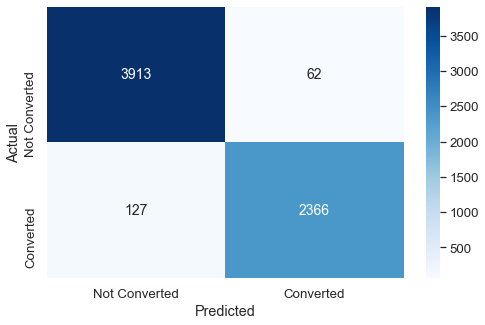

In [192]:

conf = confusion_matrix(y_train, y_train_pred)
df_cm = pd.DataFrame(conf, columns=['Not Converted' , 'Converted'], index = ['Not Converted', 'Converted'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,5))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 14} , fmt='d')

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

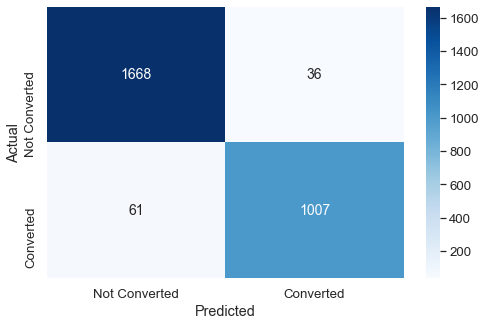

In [193]:

conf = confusion_matrix(y_test, y_test_pred)
df_cm = pd.DataFrame(conf, columns=['Not Converted' , 'Converted'], index = ['Not Converted', 'Converted'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,5))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 14} , fmt='d')

In [194]:
roc_auc_score(y_train, y_pred_train_proba)

0.9958169162964476

In [195]:
roc_auc_score(y_test, y_pred_test_proba)

0.9933770067345395

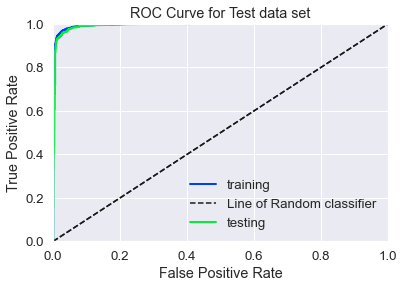

In [199]:
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_pred_train_proba)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_pred_test_proba)


plot_roc_curve(train_fpr1, train_tpr1)
plt.title("ROC Curve for Train data set")

plot_roc_curve(test_fpr1, test_tpr1)
plt.title("ROC Curve for Test data set")
plt.legend(['training', 'Line of Random classifier', 'testing'])

### Histogram of predicted probabilities: This will help us identify if the model is confident or just a good guesser!

<AxesSubplot:>

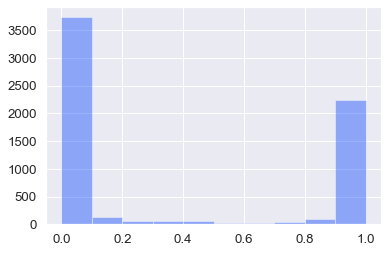

In [200]:
sns.distplot(y_pred_train_proba, kde=False)

<AxesSubplot:>

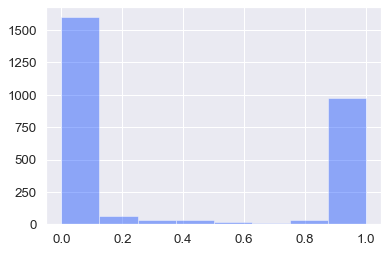

In [201]:
sns.distplot(y_pred_test_proba, kde=False)


#### Summary:
* A Histogram of predicted probabilities with 2 peeks are the 0 and 1 ends indicate a confident model in its predictions.

# Lead Score Calulator!
* Sample input: 03.Low, Modified, Unemployed, SMS Sent, Other Leads, Google, 131, Not Sure, Ringing

In [202]:
corrected_features.remove('Converted')
corrected_features

['Asymmetrique Activity Index',
 'Last Notable Activity',
 'What is your current occupation',
 'Last Activity',
 'Lead Profile',
 'Lead Source',
 'Total Time Spent on Website',
 'Lead Quality',
 'Tags',
 'Converted']

In [212]:
Asymmetrique_Activity_Index, Last_Notable_Activity, What_is_your_current_occupation, Last_Activity, Lead_Profile,Lead_Source, Total_Time_Spent_on_Website, Lead_Quality, Tags = input().split(',')



03.Low, Modified, Unemployed, SMS Sent, Other Leads, Google, 131, Not Sure, Ringing


In [213]:
prod_data=pd.DataFrame({k:v for k, v in zip(corrected_features, [Asymmetrique_Activity_Index, Last_Notable_Activity, What_is_your_current_occupation,
Last_Activity, Lead_Profile,Lead_Source, Total_Time_Spent_on_Website, Lead_Quality, Tags])}, index=[0])
print('Score [0-1] of this customer turning out to be a lead =',trained_pipeline.predict_proba(prod_data)[:,1]*100)

Score [0-1] of this customer turning out to be a lead = [12.92382009]


In [209]:
for x in X_train.columns:
    print(x,':',X_train[x].unique(),'\n')

Asymmetrique Activity Index : ['03.Low' '02.Medium' '01.High'] 

Last Notable Activity : ['Modified' 'Email Opened' 'SMS Sent' 'Page Visited on Website'
 'Last Notable Activity.0' 'Olark Chat Conversation' 'Email Link Clicked'] 

What is your current occupation : ['Unemployed' 'Student' 'Working Professional' 'Housewife' 'Other'
 'Businessman'] 

Last Activity : ['Olark Chat Conversation' 'Converted to Lead' 'Email Opened' 'SMS Sent'
 'Page Visited on Website' 'Email Bounced' 'Last Activity.0'] 

Lead Profile : ['Other Leads' 'Select' 'Student of SomeSchool' 'Potential Lead'
 'Lateral Student' 'Dual Specialization Student'] 

Lead Source : ['Google' 'Direct Traffic' 'Olark Chat' 'Reference' 'Organic Search'
 'Welingak Website' 'Lead Source.0'] 

Total Time Spent on Website : [ 248.  554.    0. ... 1197. 1140. 1038.] 

Lead Quality : ['Worst' 'High in Relevance' 'Might be' 'Not Sure' 'Low in Relevance'] 

Tags : ['Interested in other courses' 'Tags.0' 'Worst'
 'Will revert after reading